In [ ]:
#Only do once
#!pip install --target=/content/drive/MyDrive/jungfrau4M_data git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch commentjson

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "/content/drive/MyDrive/jungfrau4M_data")

In [ ]:
f = np.load("/content/drive/MyDrive/jungfrau4M_data/cxilp9515_113.npz")
mask = f["mask"]
ped = f["ped"]
gain = f["gain"]
rawList = f["rawList"]
calibList = f["calibList"]
print(calibList.shape) # 39 images

(39, 32, 185, 388)


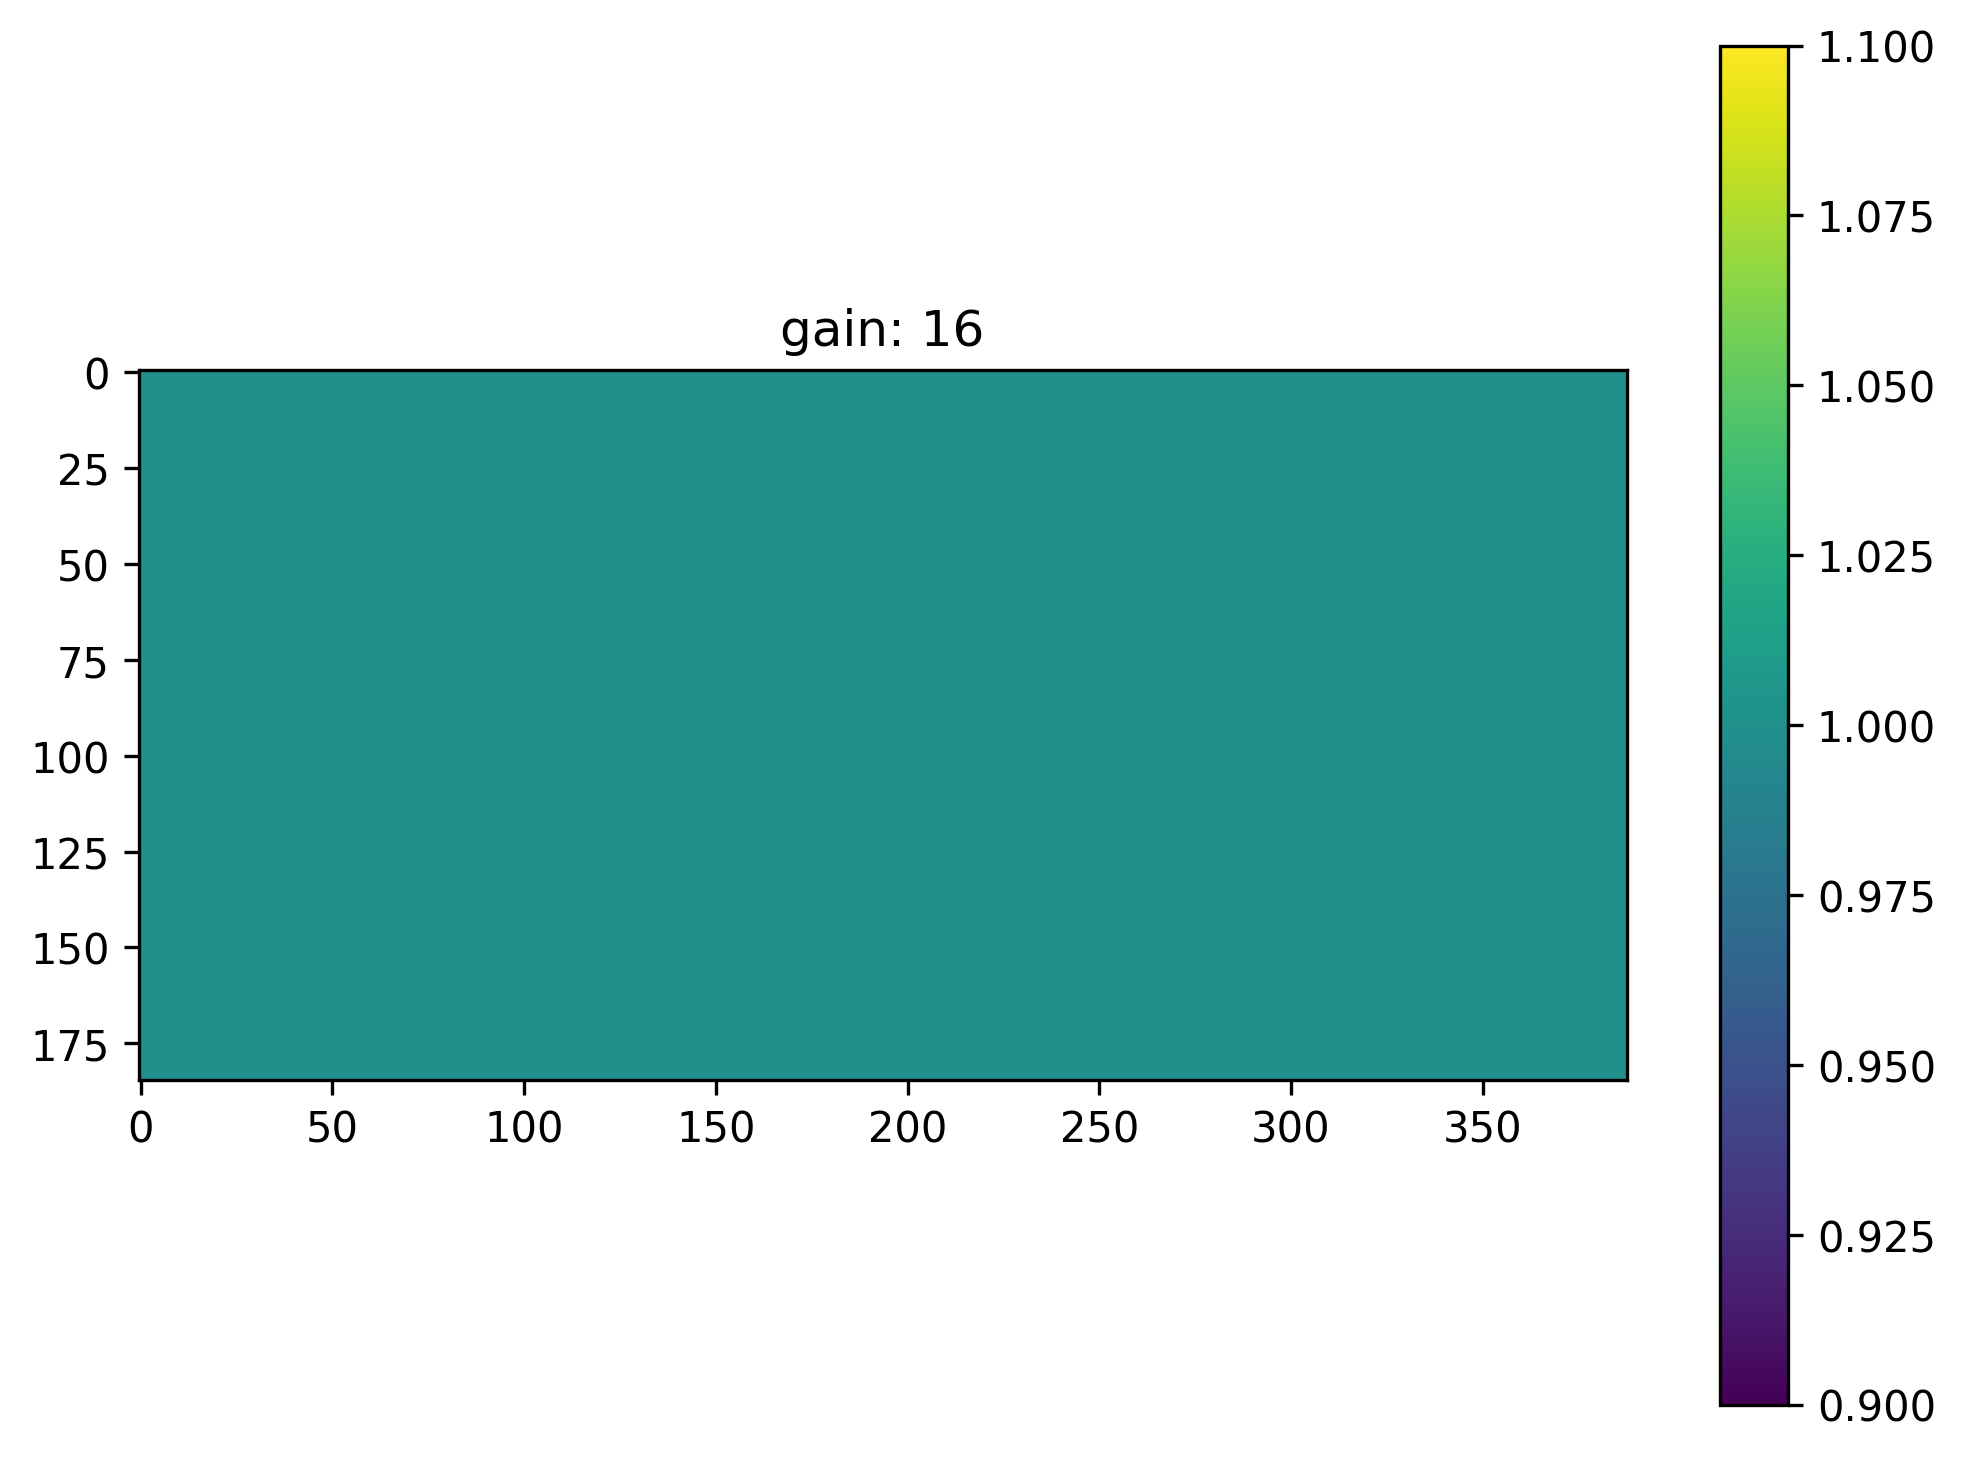

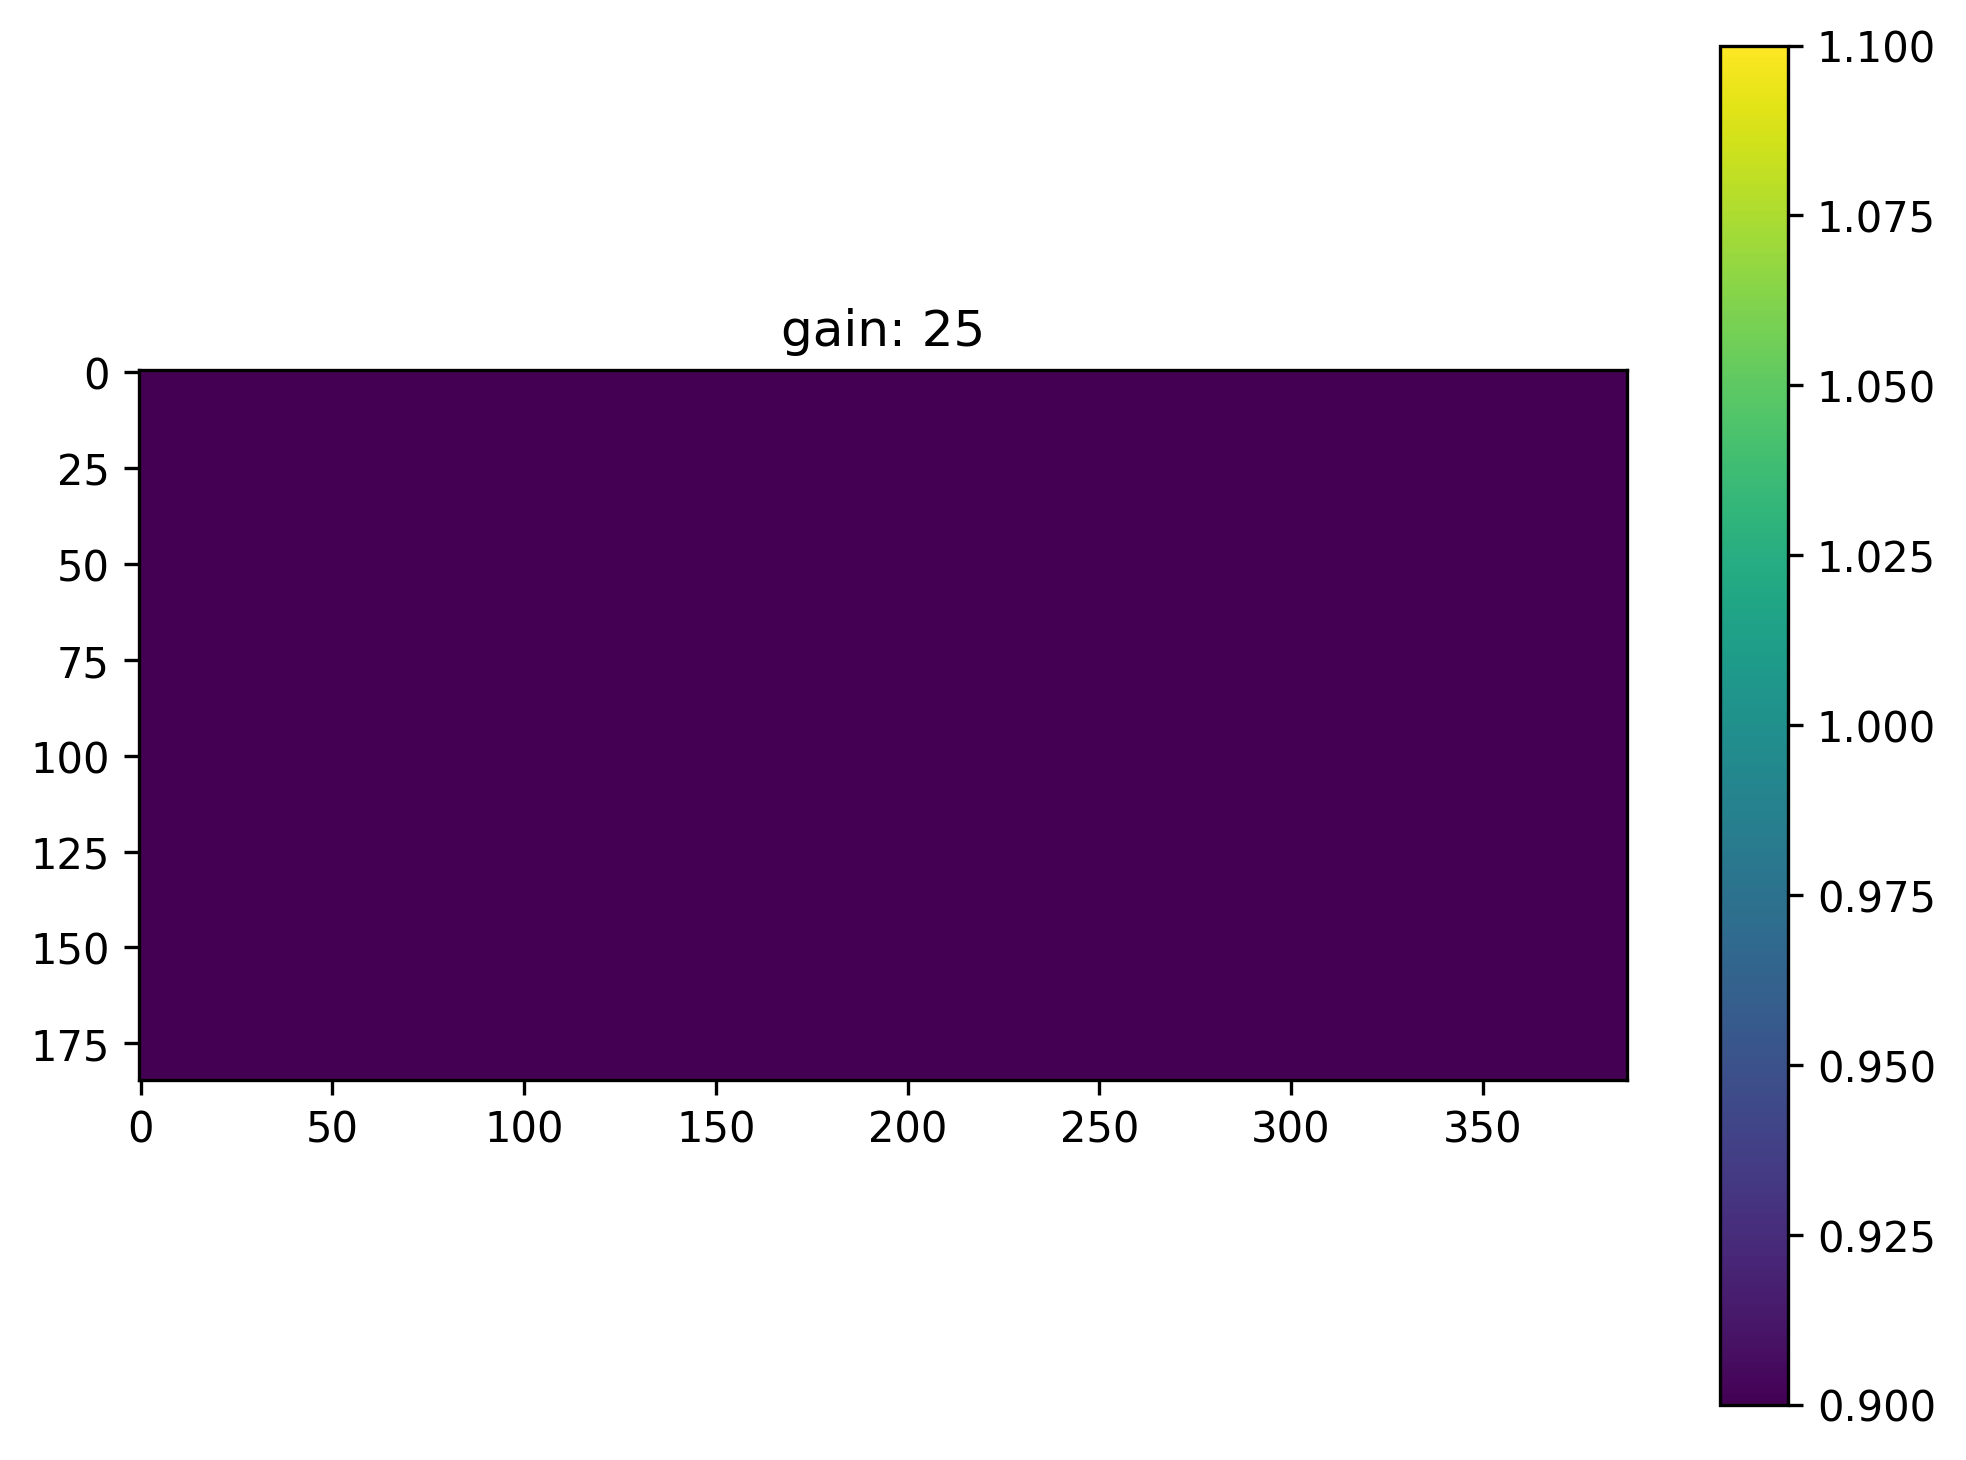

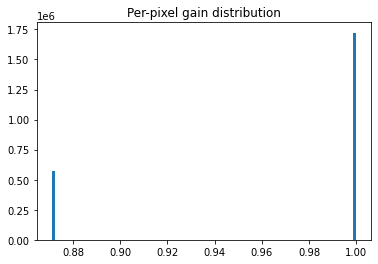

In [ ]:
for i in [16,25]:
  plt.figure(figsize=(8, 6), dpi=300)
  plt.imshow(gain[i],interpolation='none',vmin=0.9,vmax=1.1); plt.title(f"gain: {i}"); plt.colorbar(); plt.show()
plt.hist(gain.ravel(),bins=100); plt.title("Per-pixel gain distribution"); plt.show()

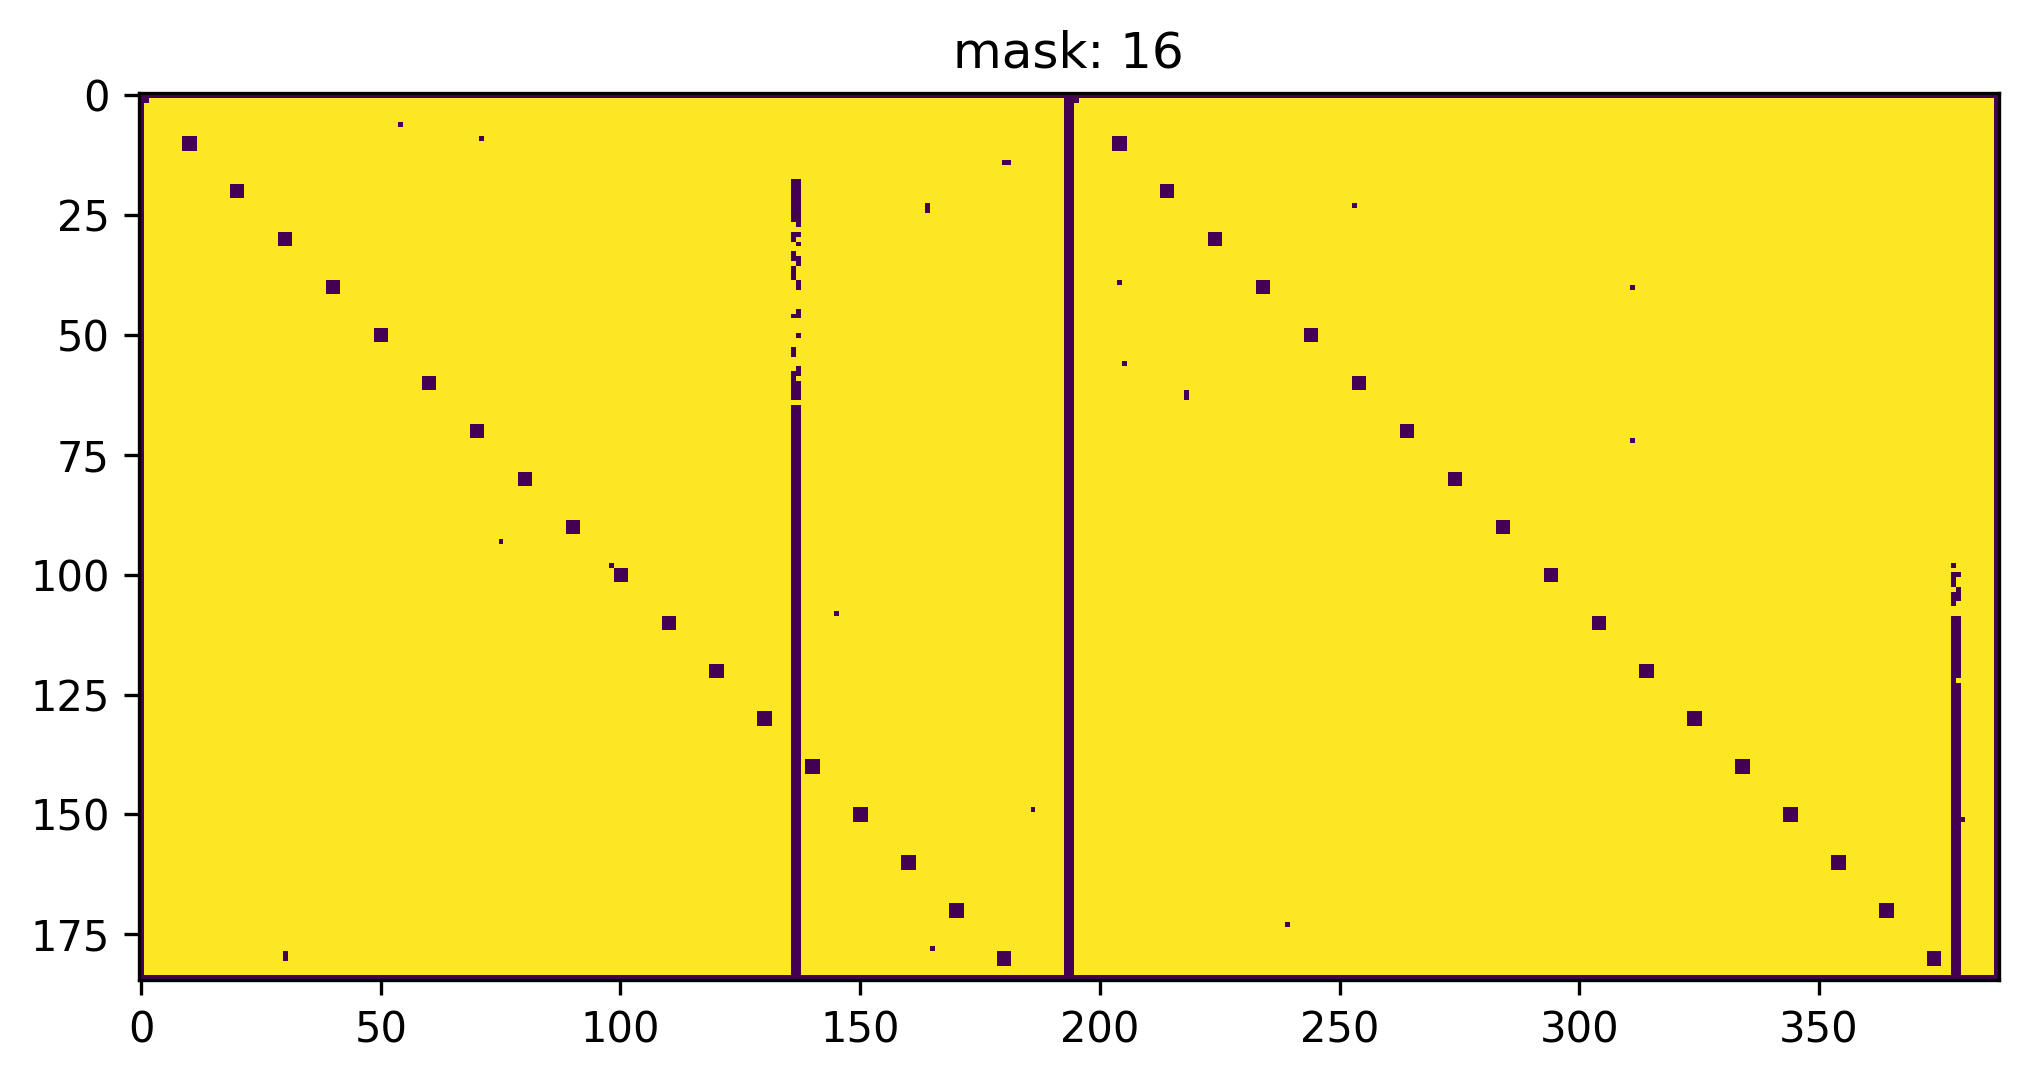

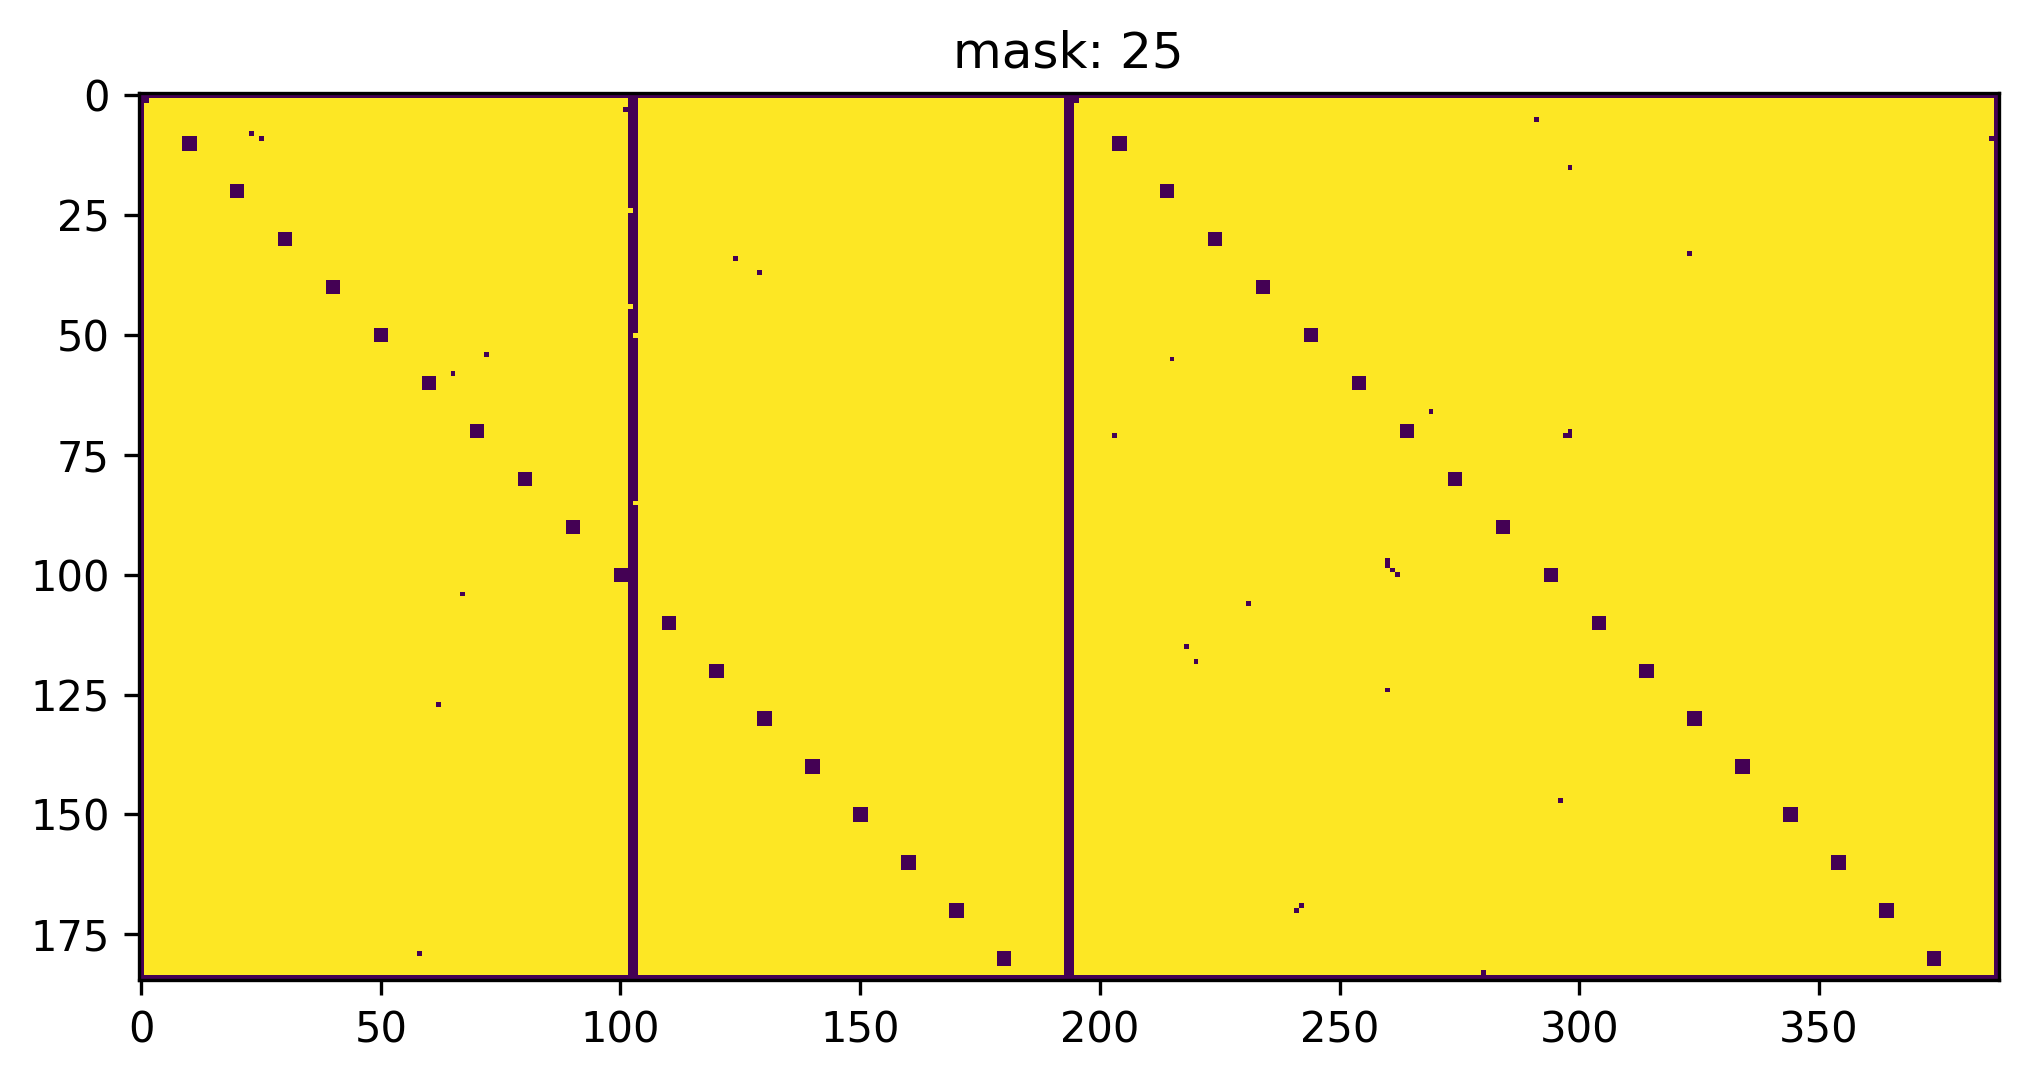

In [ ]:
for i in [16,25]:
  plt.figure(figsize=(8, 6), dpi=300)
  plt.imshow(mask[i],interpolation='none'); plt.title(f"mask: {i}"); plt.show()

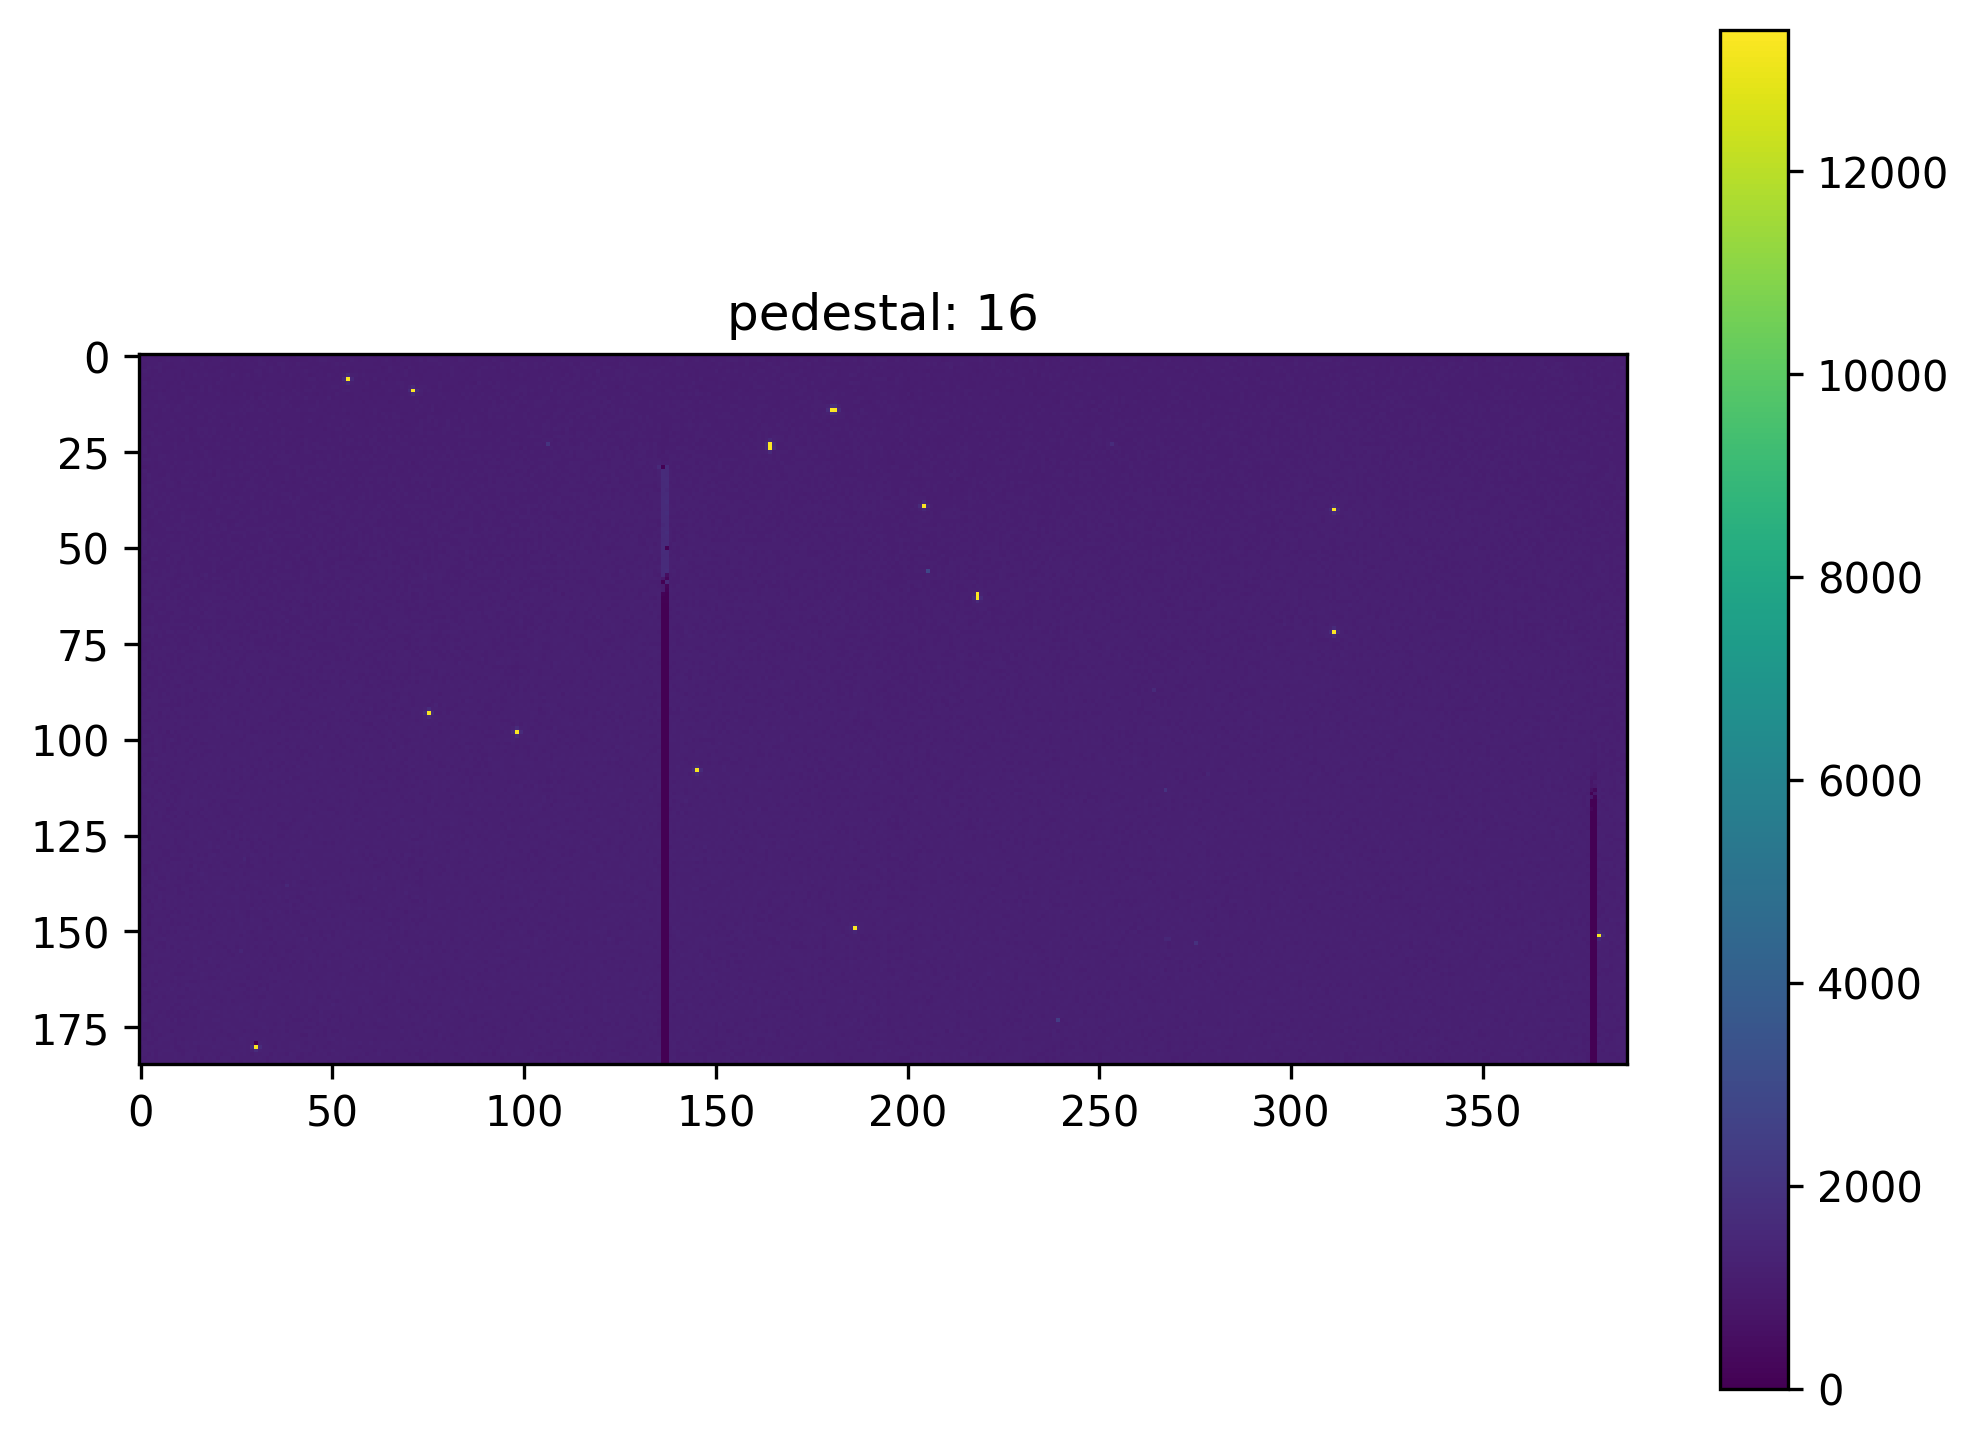

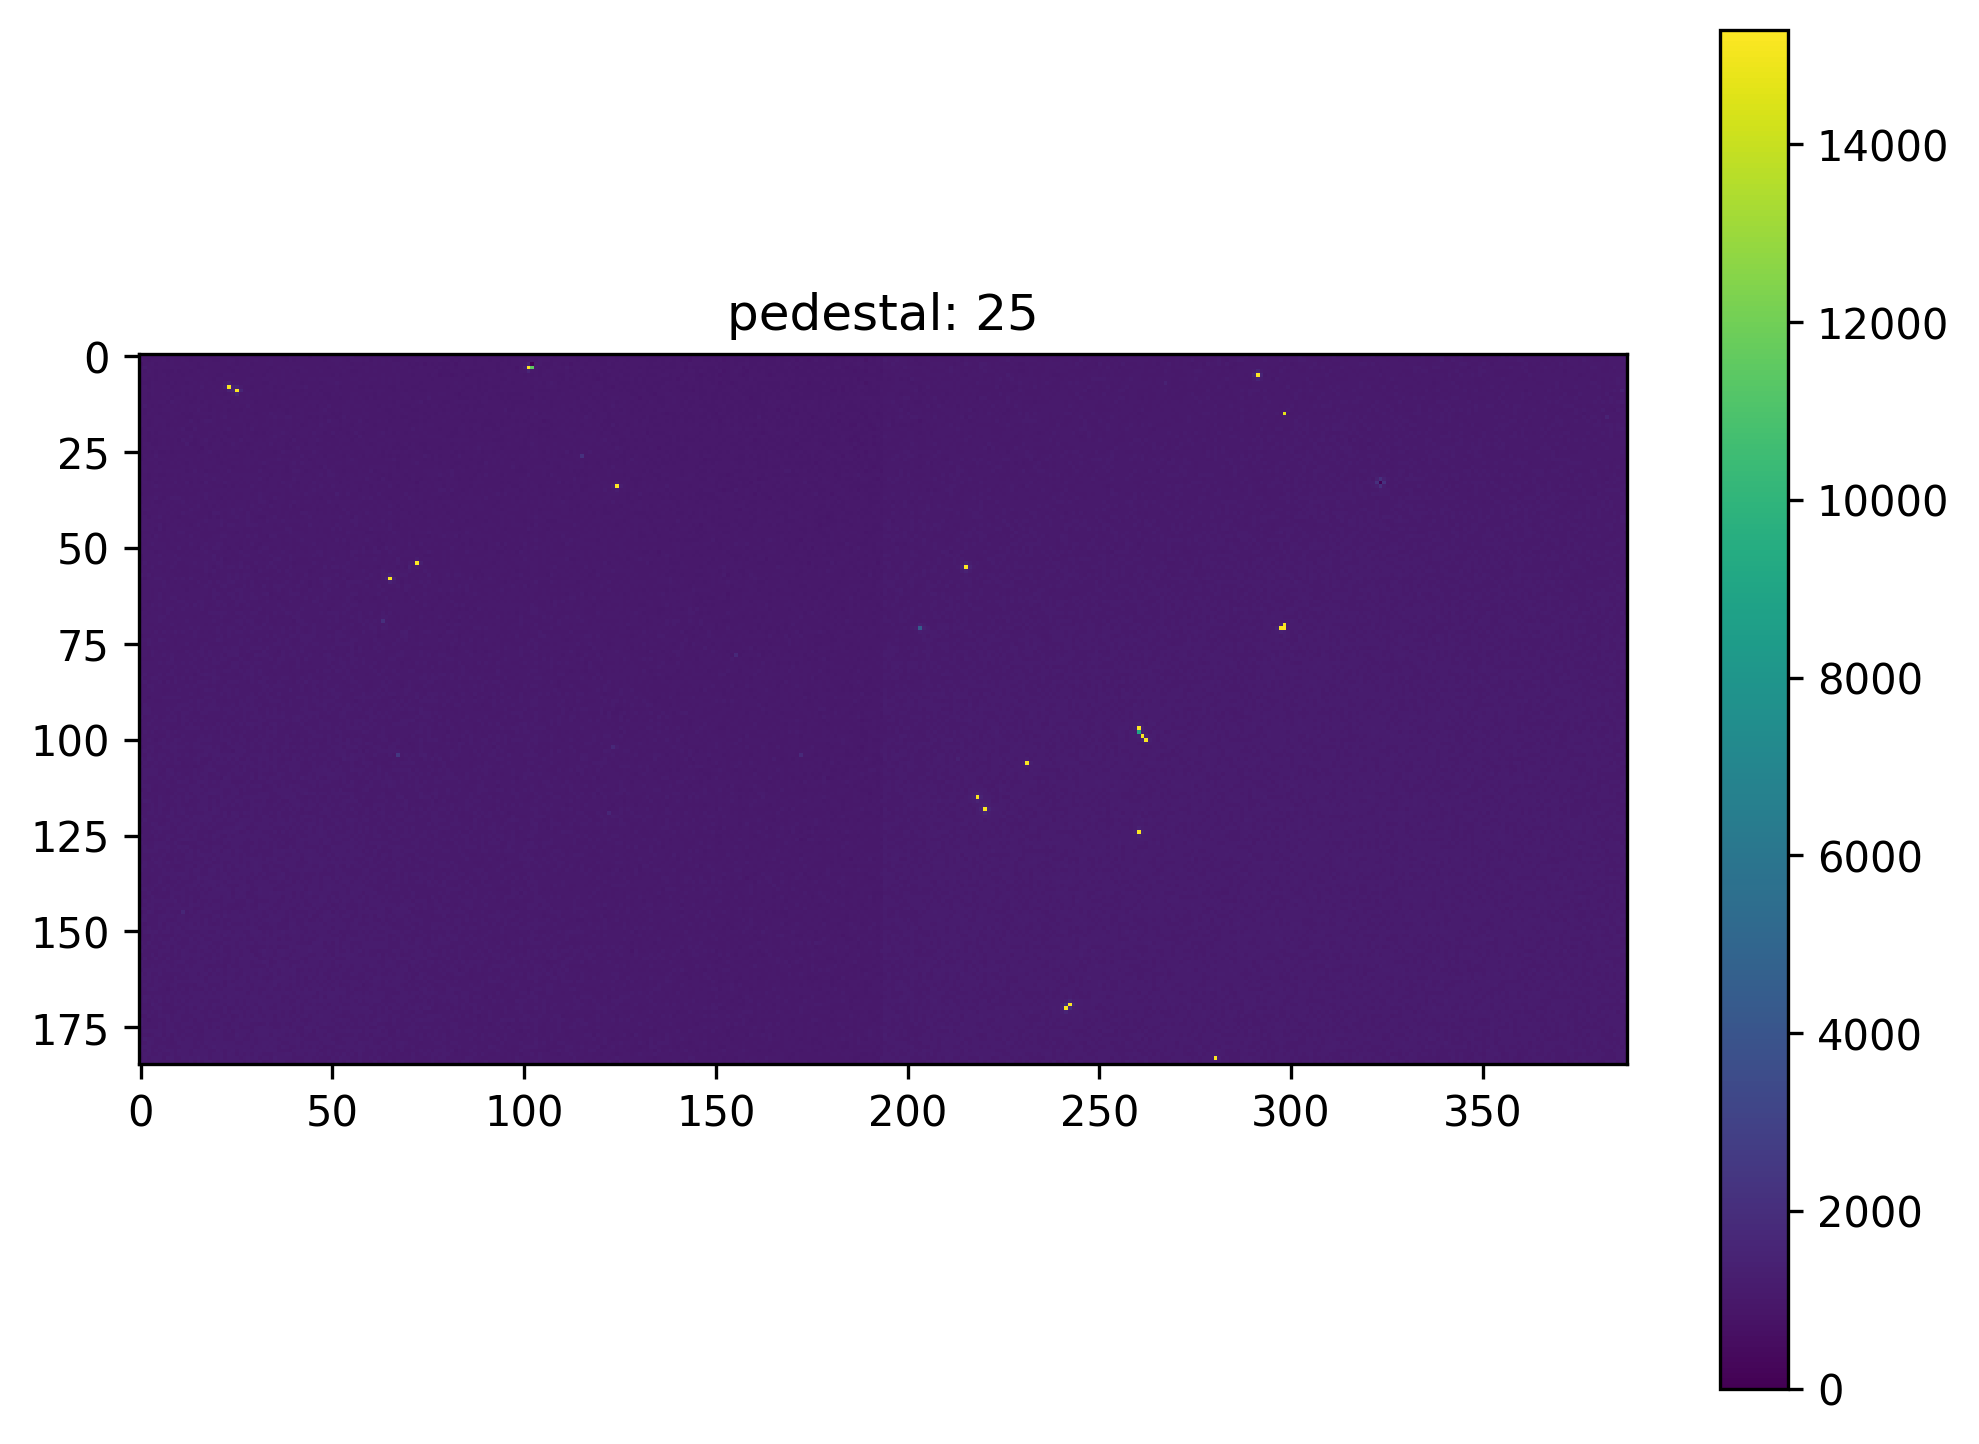

In [ ]:
for i in [16,25]:
  plt.figure(figsize=(8, 6), dpi=300)
  plt.imshow(ped[i],interpolation='none'); plt.title(f"pedestal: {i}"); plt.colorbar(); plt.show()

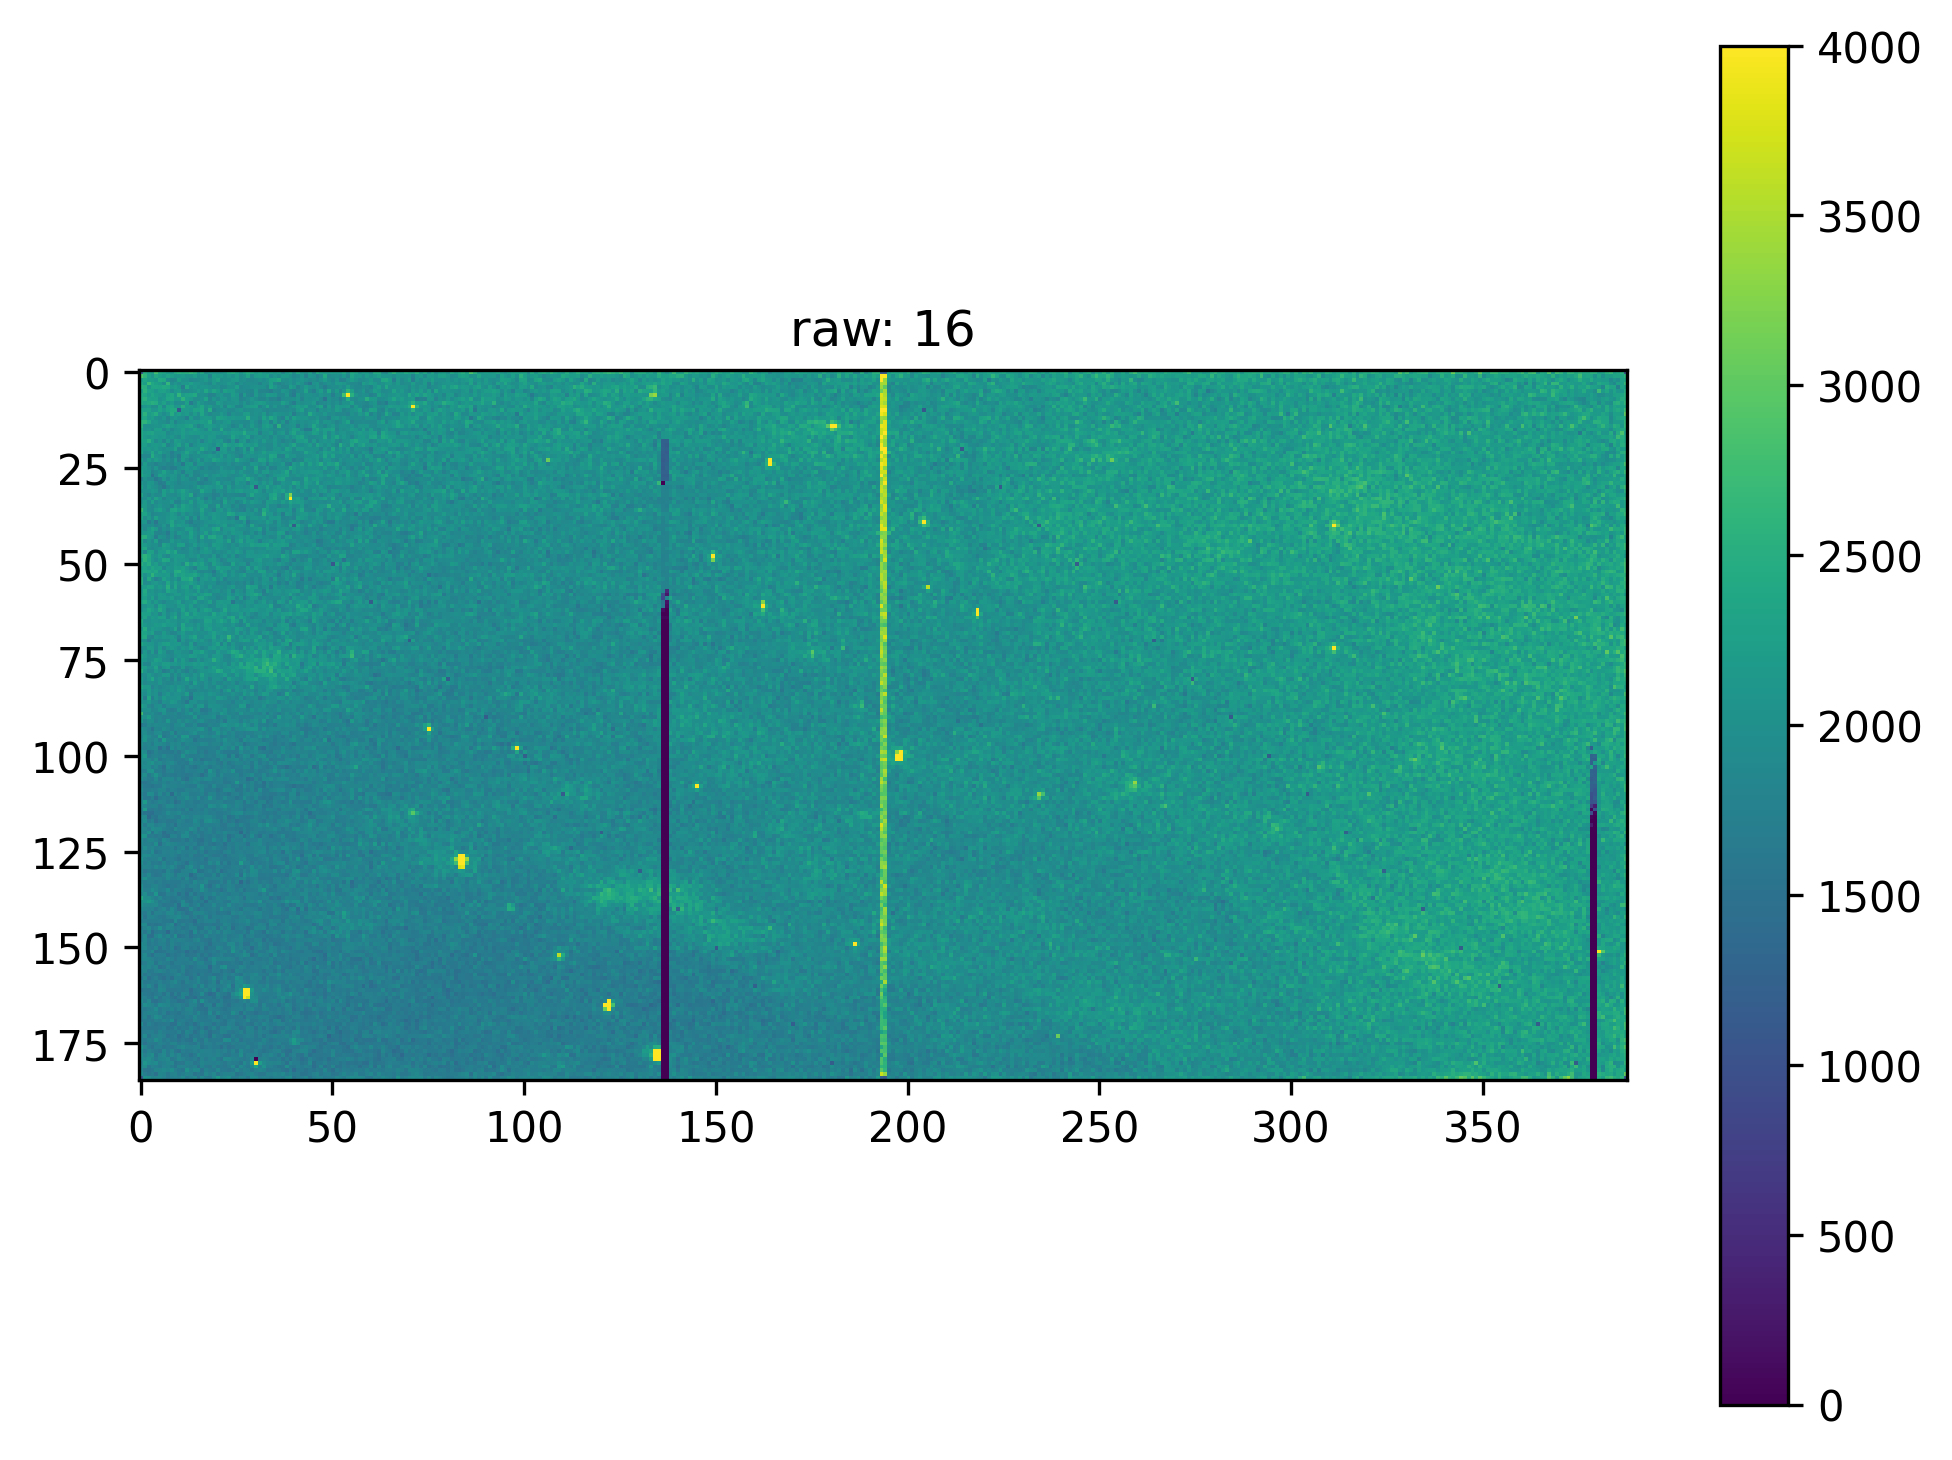

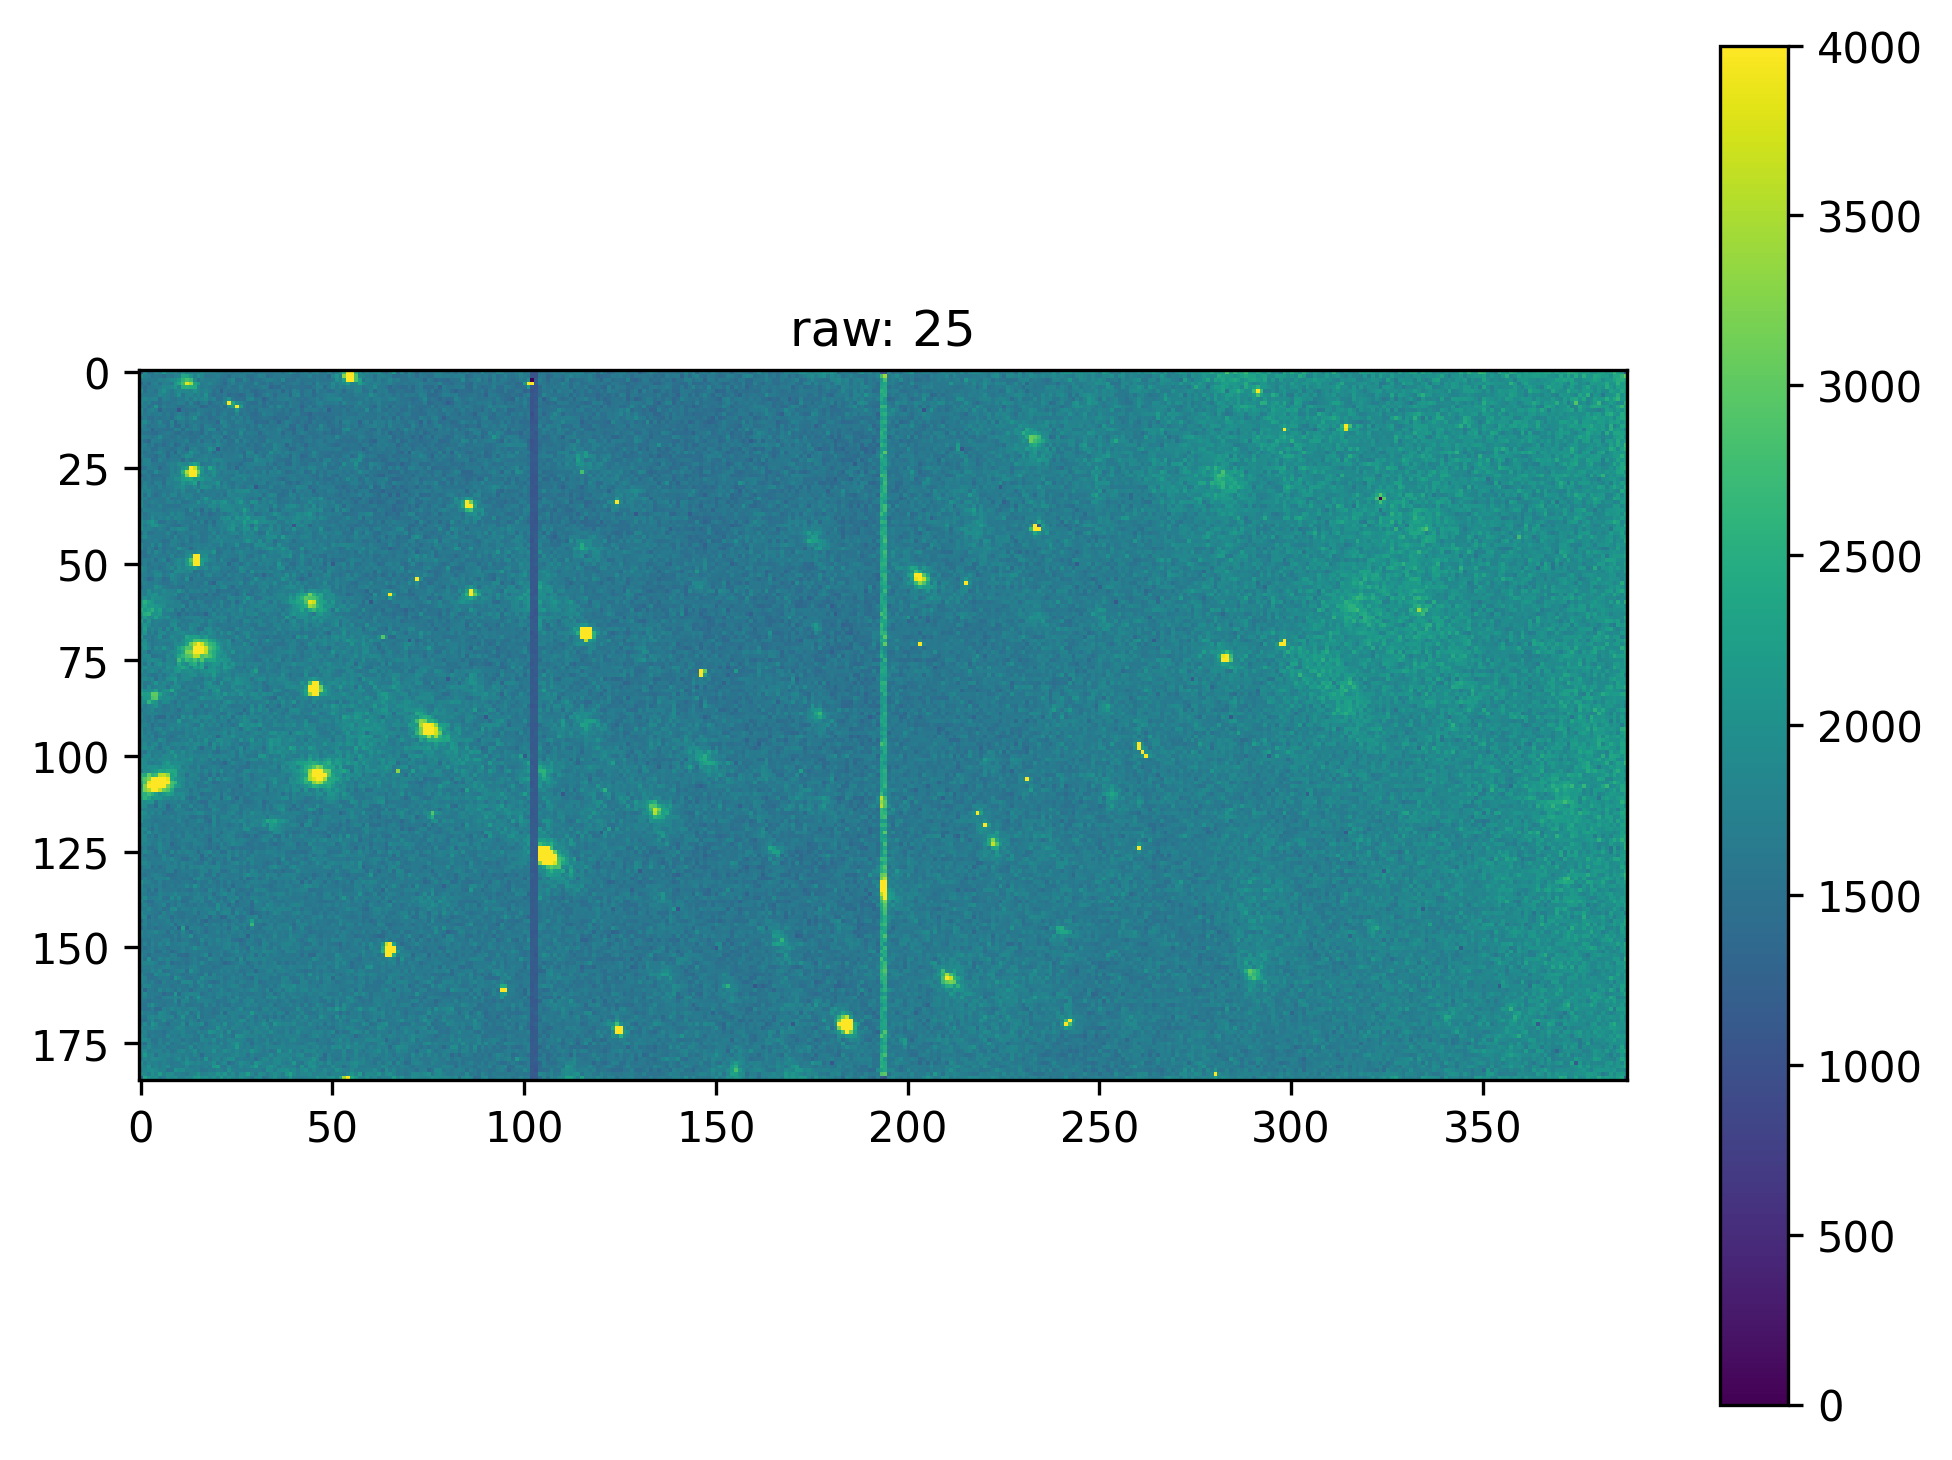

In [ ]:
for i in [16,25]:
  plt.figure(figsize=(8, 6), dpi=300)
  plt.imshow(rawList[0,i],interpolation='none',vmin=0,vmax=4000); plt.title(f"raw: {i}"); plt.colorbar(); plt.show()

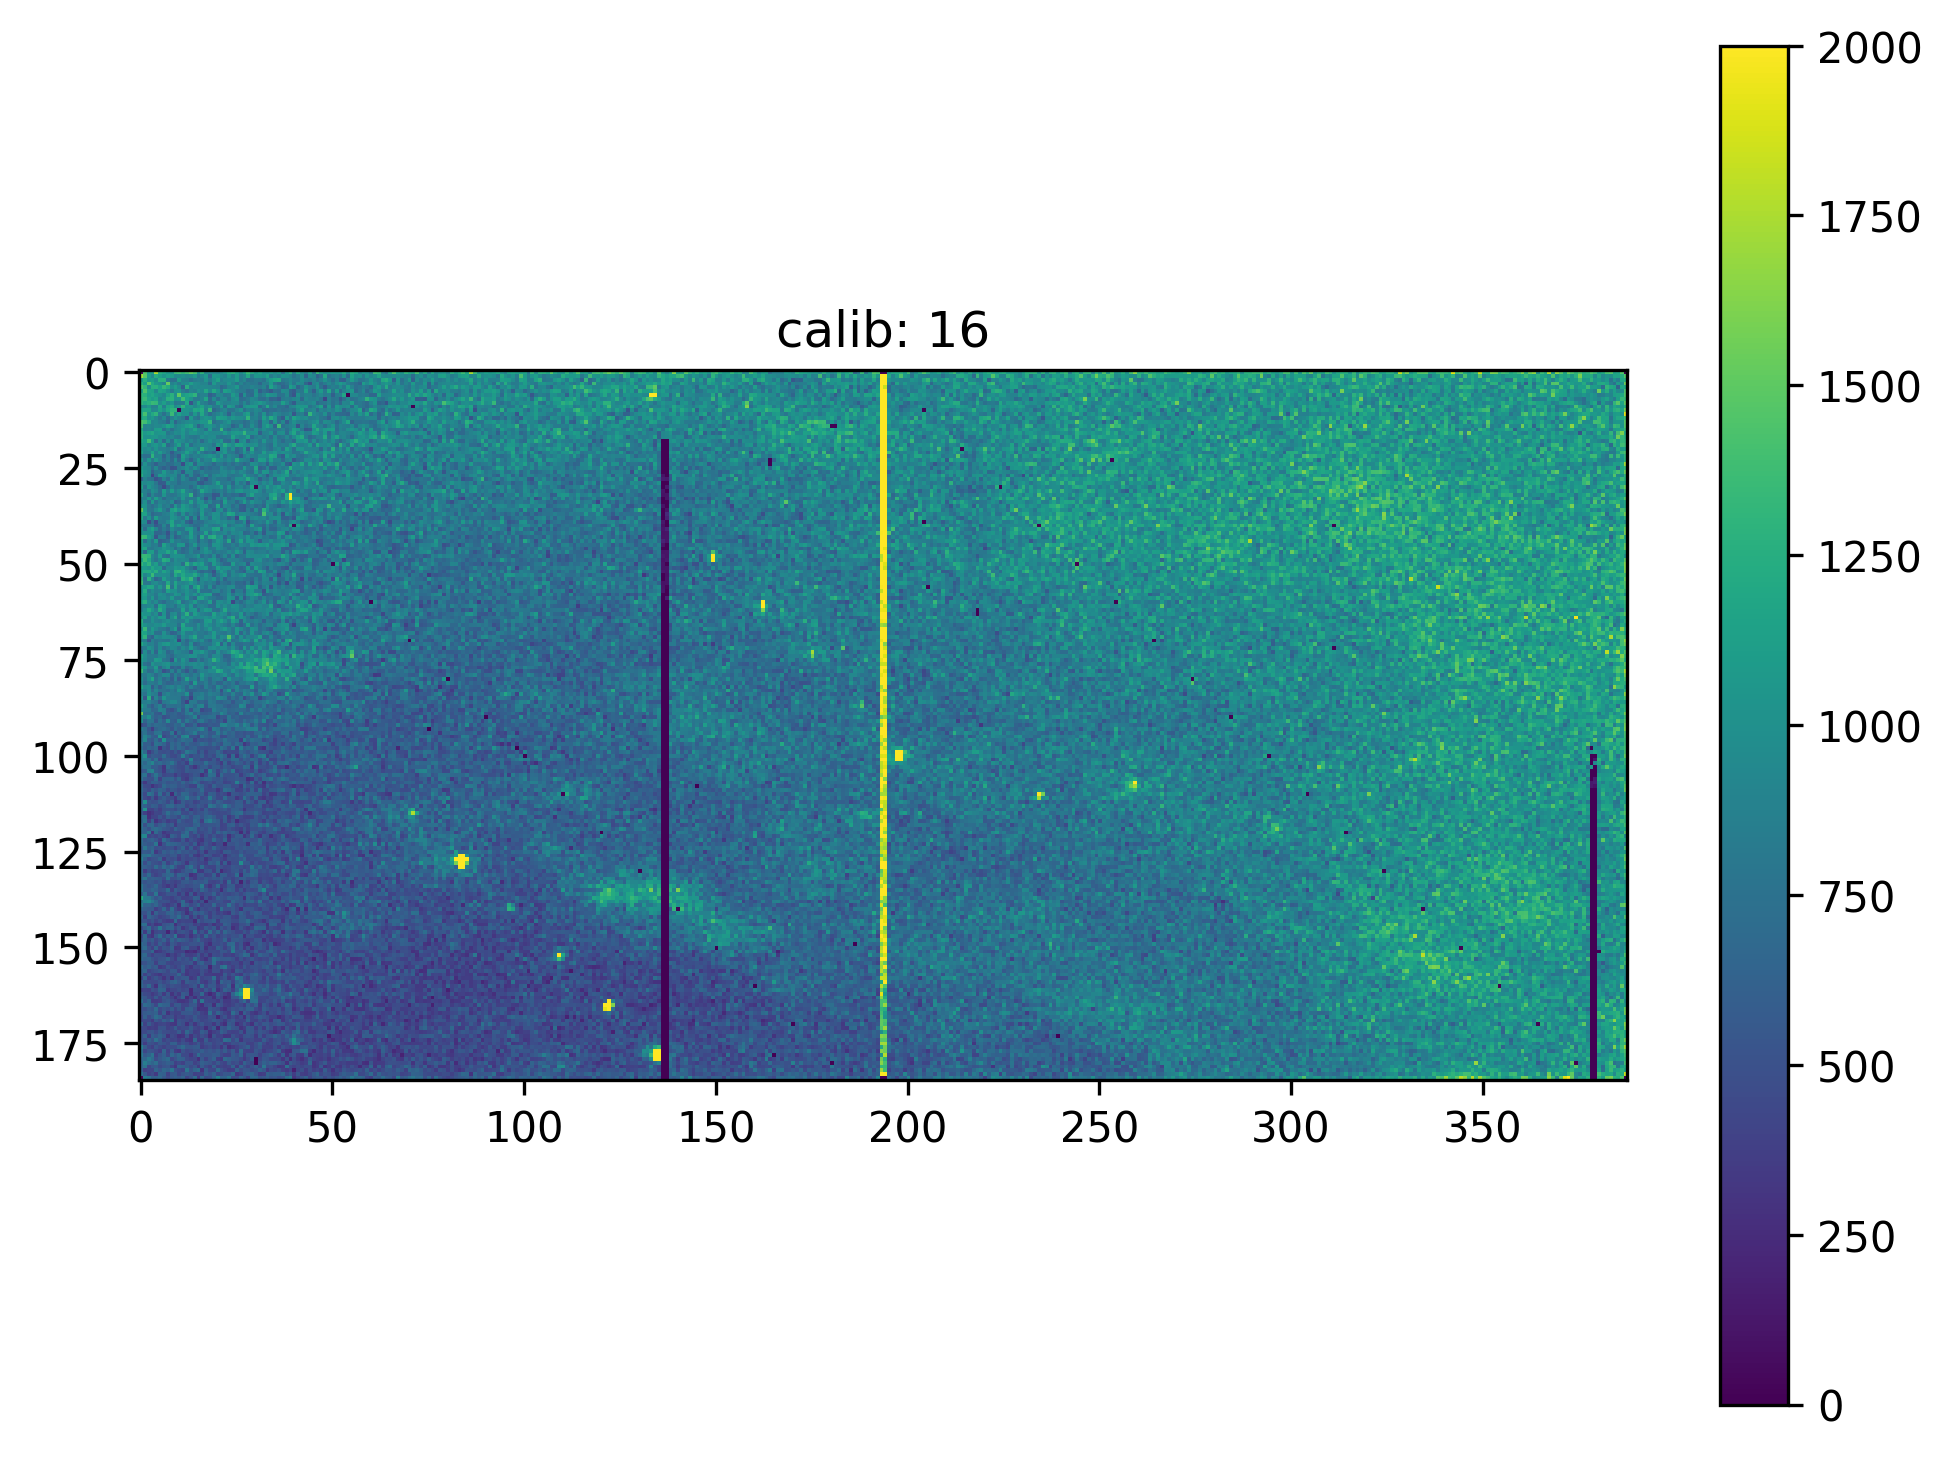

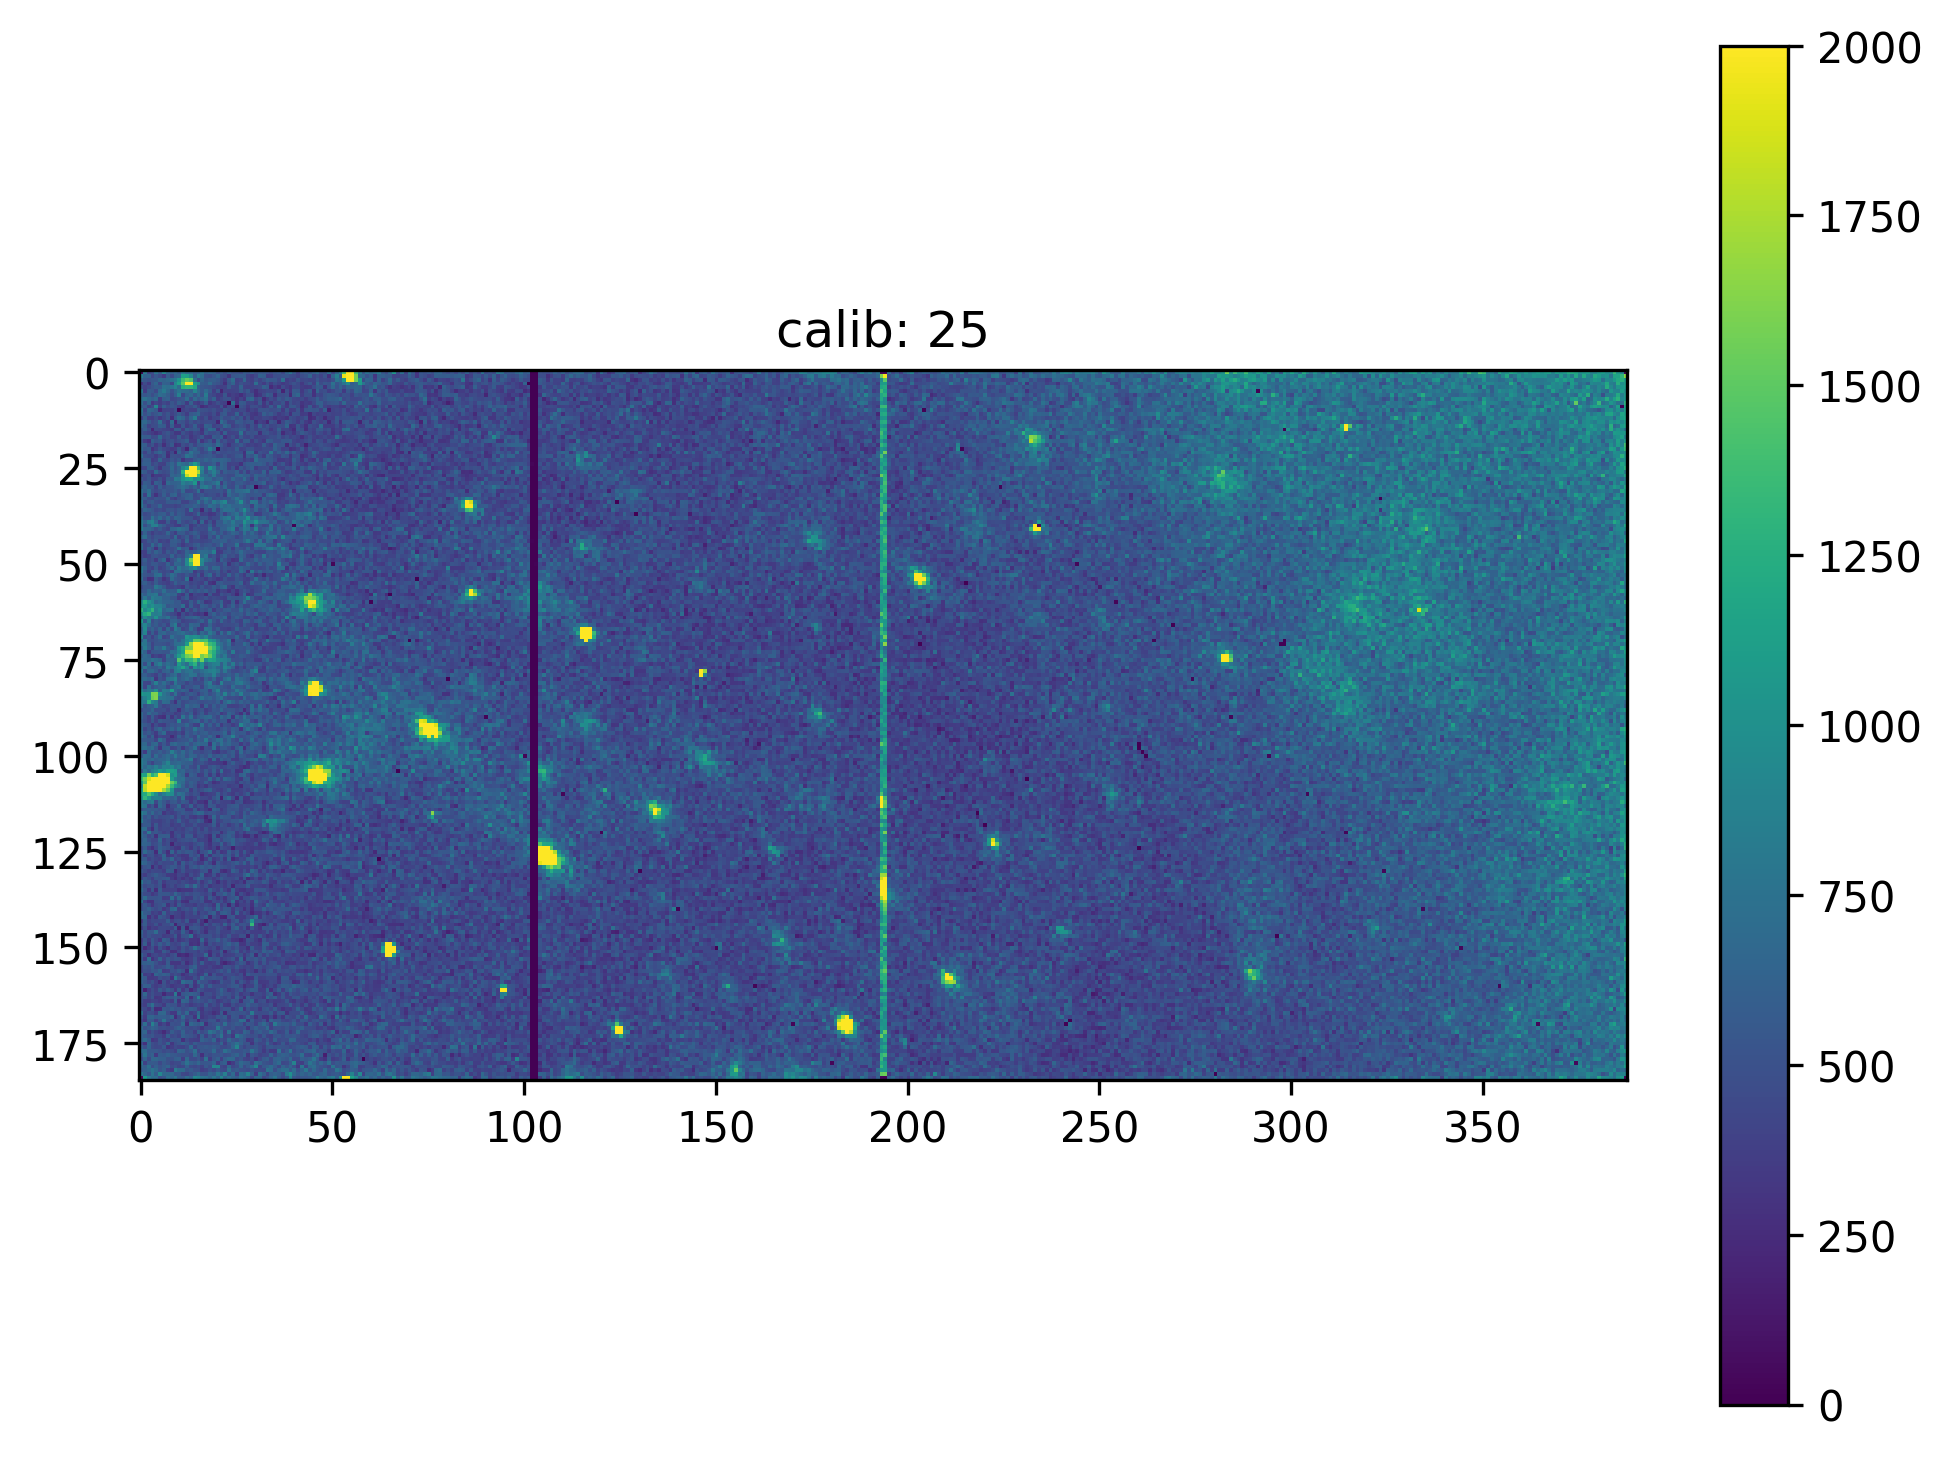

In [ ]:
for i in [16,25]:
  plt.figure(figsize=(8, 6), dpi=300)
  plt.imshow(calibList[0,i],interpolation='none',vmin=0,vmax=2000); plt.title(f"calib: {i}"); plt.colorbar(); plt.show()

In [ ]:
import argparse
import commentjson as json
import os
import torch
import time

# Sample application that uses the tiny cuda nn framework to learn a
# 2D function that represents an image.

try:
	import tinycudann as tcnn
except ImportError:
	print("This sample requires the tiny-cuda-nn extension for PyTorch.")
	print("You can install it by running:")
	print("============================================================")
	print("tiny-cuda-nn$ cd bindings/torch")
	print("tiny-cuda-nn/bindings/torch$ python setup.py install")
	print("============================================================")
	sys.exit()

SCRIPTS_DIR = "/content/drive/MyDrive/tiny-cuda-nn/scripts" #os.path.join(os.path.dirname(os.path.dirname(__file__)), "scripts")
sys.path.insert(0, SCRIPTS_DIR)
print(sys.path)

from common import read_image, write_image, ROOT_DIR

DATA_DIR = os.path.join(ROOT_DIR, "data")
IMAGES_DIR = os.path.join(DATA_DIR, "images")

class Image(torch.nn.Module):
	def __init__(self, data, device):
		super(Image, self).__init__()
		self.data = data #read_image(filename)
		self.shape = self.data.shape
		print(self.shape)
		self.data = torch.from_numpy(self.data).float().to(device)

	def forward(self, xs):
		with torch.no_grad():
			# Bilinearly filtered lookup from the image. Not super fast,
			# but less than ~20% of the overall runtime of this example.
			shape = self.shape

			xs = xs * torch.tensor([shape[1], shape[0]], device=xs.device).float()
			indices = xs.long()
			lerp_weights = xs - indices.float()

			x0 = indices[:, 0].clamp(min=0, max=shape[1]-1)
			y0 = indices[:, 1].clamp(min=0, max=shape[0]-1)
			x1 = (x0 + 1).clamp(max=shape[1]-1)
			y1 = (y0 + 1).clamp(max=shape[0]-1)

			return (
				# TODO: fix biased estimation in intensities
				self.data[y0, x0] * (1.0 - lerp_weights[:,0:1]) * (1.0 - lerp_weights[:,1:2]) +
				self.data[y0, x1] * lerp_weights[:,0:1] * (1.0 - lerp_weights[:,1:2]) +
				self.data[y1, x0] * (1.0 - lerp_weights[:,0:1]) * lerp_weights[:,1:2] +
				self.data[y1, x1] * lerp_weights[:,0:1] * lerp_weights[:,1:2]
			)

['/content/drive/MyDrive/tiny-cuda-nn/scripts', '/content/drive/MyDrive/jungfrau4M_data', '/content/drive/MyDrive/tiny-cuda-nn/scripts', '/content/drive/MyDrive/jungfrau4M_data', '/content/drive/MyDrive/jungfrau4M_data', '/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
device = torch.device("cuda")

In [ ]:
def normalize(img):
  # normalize image between 0 and 1
  minI = np.min(img)
  img = img - minI
  maxI = np.max(img)
  img = img / maxI
  return img, minI, maxI

In [ ]:
calib = calibList[0]
raw = rawList[0]
print(np.min(calib), np.max(calib))
print(np.min(raw), np.max(raw))

del rawList, calibList

-1183.37 13305.856
0 16383


In [ ]:
class Args:
    pass
args = Args()

seg = 25
rawN, minR, maxR = normalize(raw[seg] * mask[seg])
args.image = np.expand_dims(rawN, axis=2)
#args.image = np.expand_dims(normalize(calib[seg]), axis=2)
args.config = "/content/drive/MyDrive/tiny-cuda-nn/data/config_hash.json"
args.n_steps = 1000
args.result_filename = ""

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
with open(args.config) as config_file:
		config = json.load(config_file)
pp.pprint(config)

{   'encoding': {   'base_resolution': 16,
                    'log2_hashmap_size': 15,
                    'n_features_per_level': 2,
                    'n_levels': 16,
                    'otype': 'HashGrid',
                    'per_level_scale': 1.5},
    'loss': {'otype': 'RelativeL2'},
    'network': {   'activation': 'ReLU',
                   'n_hidden_layers': 2,
                   'n_neurons': 64,
                   'otype': 'FullyFusedMLP',
                   'output_activation': 'None'},
    'optimizer': {   'beta1': 0.9,
                     'beta2': 0.99,
                     'epsilon': 1e-15,
                     'l2_reg': 1e-06,
                     'learning_rate': 0.01,
                     'otype': 'Adam'}}


In [ ]:
image = Image(args.image, device)
n_channels = 1 #image.data.shape[1]
print("n_channels: ", n_channels)
print(image.data.shape)

(185, 388, 1)
n_channels:  1
torch.Size([185, 388, 1])


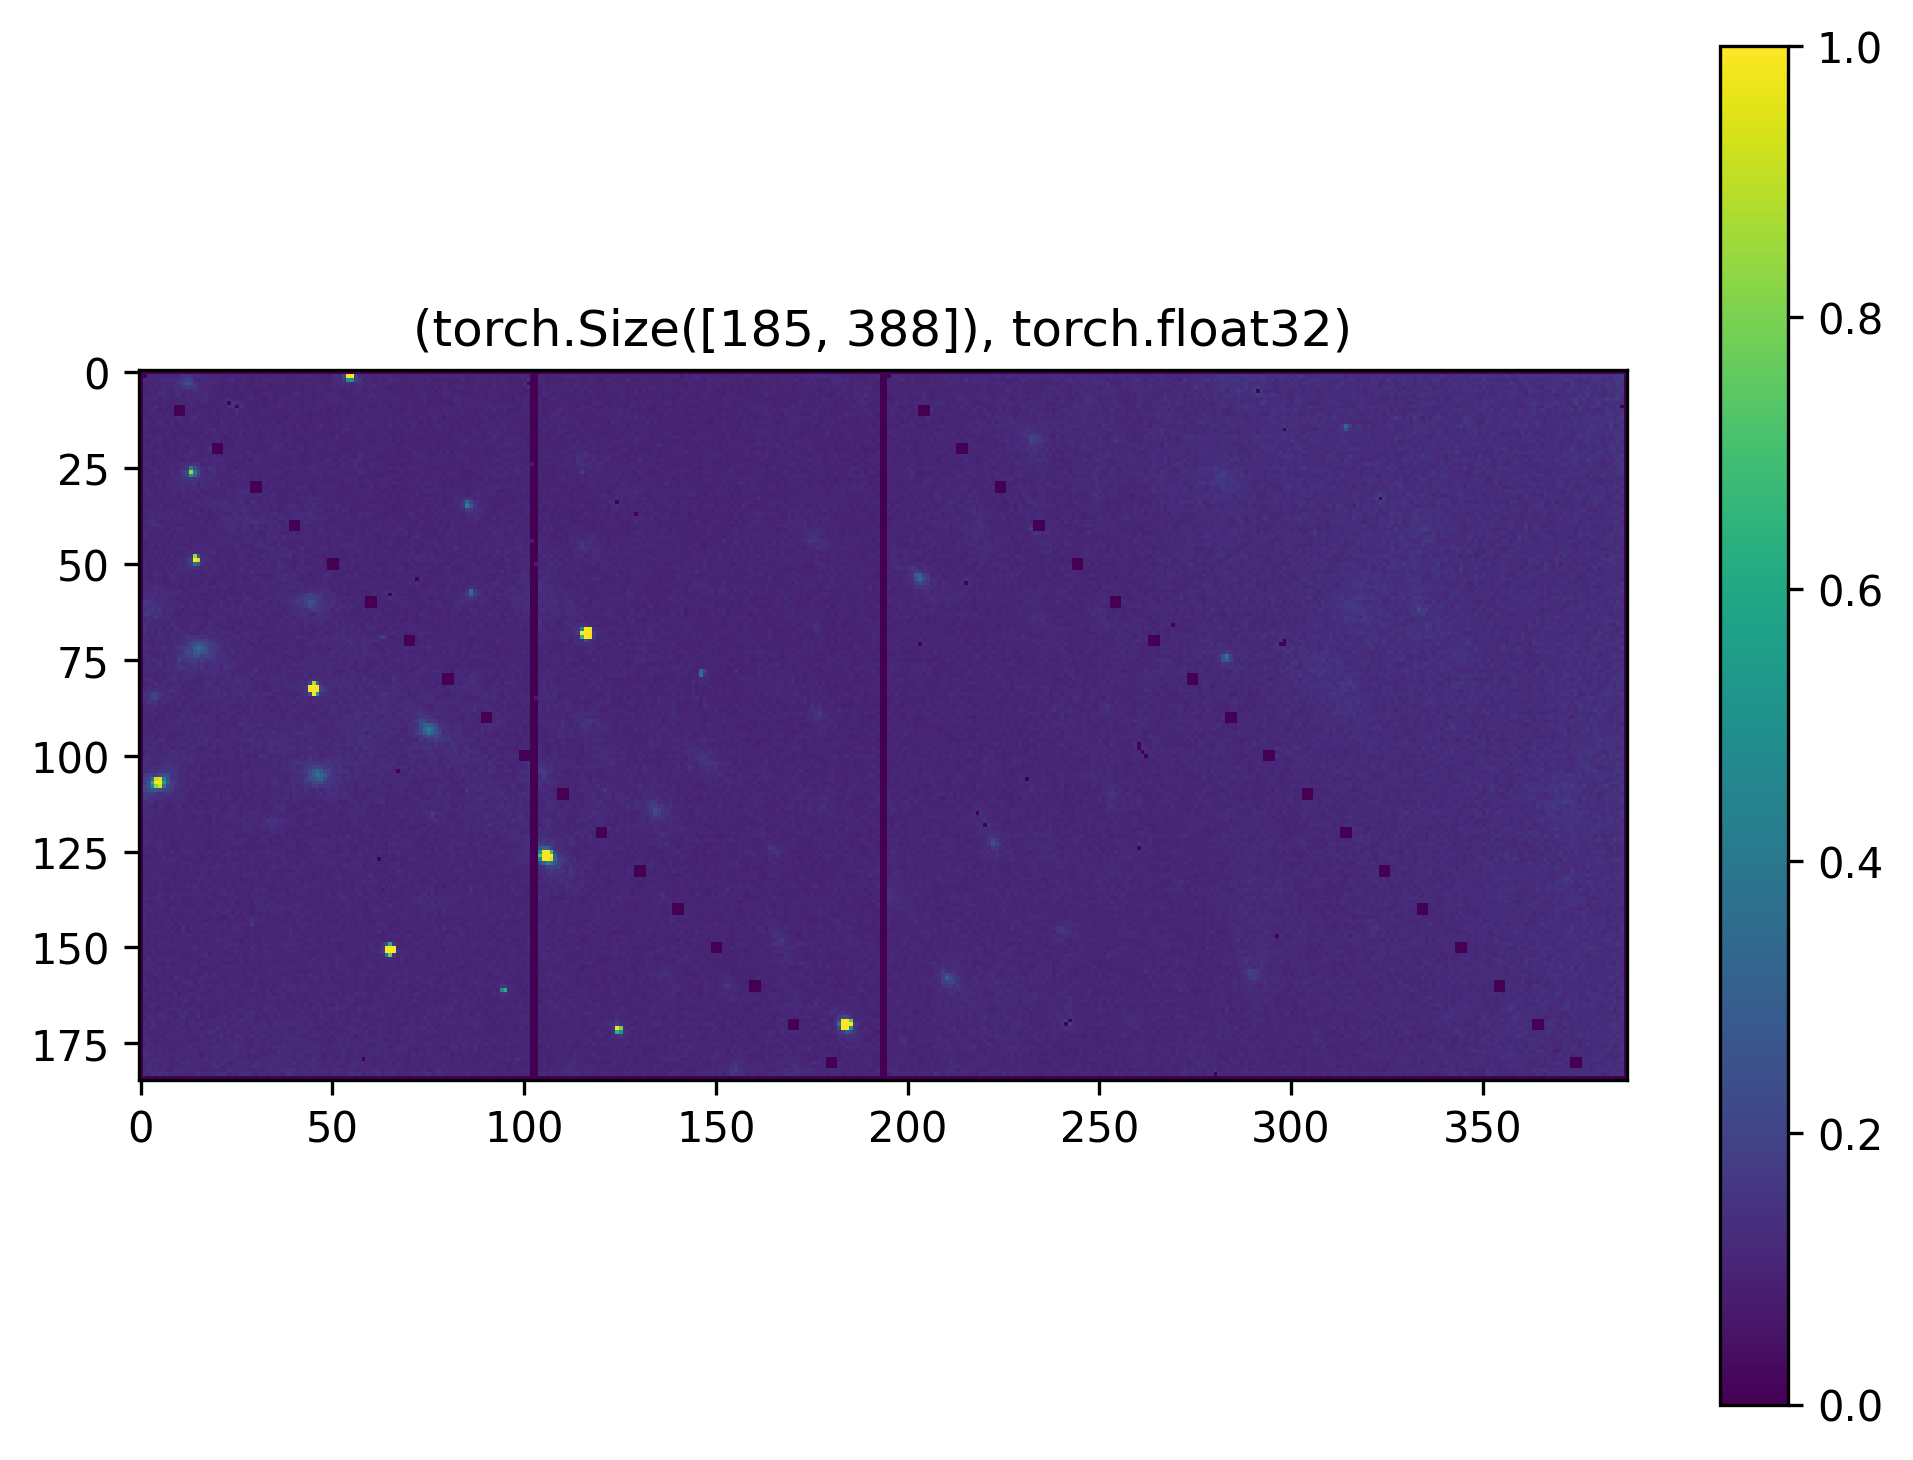

0.07178 MB


In [ ]:
import matplotlib.pyplot as plt
img = torch.Tensor.cpu(image.data[:,:,0])
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(img,interpolation='none',vmin=0,vmax=1); plt.title(f"{img.shape, img.dtype}"); plt.colorbar(); plt.show()
print(f"{img.shape[0]*img.shape[1]/1e6} MB")

In [ ]:
fast = False
if fast:
  model = tcnn.NetworkWithInputEncoding(n_input_dims=2, n_output_dims=n_channels, encoding_config=config["encoding"], network_config=config["network"]).to(device)
else:
  encoding = tcnn.Encoding(n_input_dims=2, encoding_config=config["encoding"],seed=0)
  network = tcnn.Network(n_input_dims=encoding.n_output_dims, n_output_dims=n_channels, network_config=config["network"],seed=0)
  model = torch.nn.Sequential(encoding, network)

In [ ]:
"""
  Encoding:
	Input encoding to a neural network.
	Takes a `torch.float` input tensor of shape `[:, n_input_dims]` and maps
	it to a `dtype` tensor of shape `[:, self.n_output_dims]`, where
	`self.n_output_dims` depends on `n_input_dims` and the configuration
	`encoding_config`.
"""
print(encoding) # n_input_dims=2, n_output_dims=32
print(network) # n_input_dims=32, n_output_dims=1
print(model)

Encoding(n_input_dims=2, n_output_dims=32, seed=0, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 15, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.5, 'type': 'Hash'})
Network(n_input_dims=32, n_output_dims=1, seed=0, dtype=torch.float16, hyperparams={'encoding': {'offset': 0.0, 'otype': 'Identity', 'scale': 1.0}, 'network': {'activation': 'ReLU', 'n_hidden_layers': 2, 'n_neurons': 64, 'otype': 'FullyFusedMLP', 'output_activation': 'None'}, 'otype': 'NetworkWithInputEncoding'})
Sequential(
  (0): Encoding(n_input_dims=2, n_output_dims=32, seed=0, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 15, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.5, 'type': 'Hash'})
  (1): Network(n_input_dims=32, n_output_dims=1, seed=0, dtype=torch.float16, hyperparams={'en

tensor([-8.7995e-05,  3.3404e-05, -3.4780e-05,  ..., -3.2069e-05,
         7.2561e-06,  7.6117e-06]) torch.Size([708368]) torch.float32
tensor([-0.2200, -0.2026, -0.1456,  ...,  0.1687, -0.1122, -0.1859]) torch.Size([7168]) torch.float32
0.params tensor([-8.7995e-05,  3.3404e-05, -3.4780e-05,  ..., -3.2069e-05,
         7.2561e-06,  7.6117e-06], device='cuda:0') torch.Size([708368]) torch.float32
1.params tensor([-0.2200, -0.2026, -0.1456,  ...,  0.1687, -0.1122, -0.1859],
       device='cuda:0') torch.Size([7168]) torch.float32


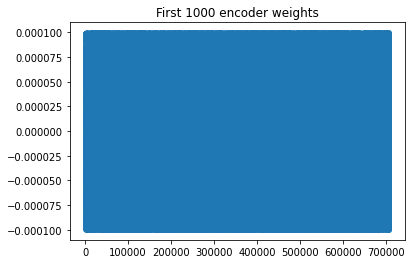

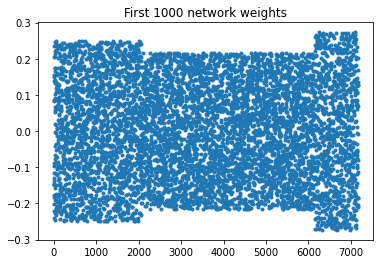

2.833472 MB + 0.028672 MB


In [ ]:
enc = torch.Tensor.cpu(encoding.params.data)
print(enc, enc.shape, enc.dtype)
weights = torch.Tensor.cpu(network.params.data)
print(weights, weights.shape, weights.dtype)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.data.size(), param.data.dtype)
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.plot(enc[:],'.'); plt.title("First 1000 encoder weights"); plt.show()
plt.plot(weights[:],'.'); plt.title("First 1000 network weights"); plt.show()
print(f"{enc.shape[0]*4/1e6} MB + {weights.shape[0]*4/1e6} MB")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Variables for saving/displaying image results
resolution = image.data.shape[0:2]
img_shape = resolution + (1,) #torch.Size([image.data.shape[2]])
n_pixels = resolution[0] * resolution[1]
print(f"res: {resolution}, img_shape: {img_shape}, n_pixels: {n_pixels}")

half_dx =  0.5 / resolution[0]
half_dy =  0.5 / resolution[1]
xs = torch.linspace(half_dx, 1-half_dx, resolution[0], device=device)
ys = torch.linspace(half_dy, 1-half_dy, resolution[1], device=device)
xv, yv = torch.meshgrid([xs, ys])
print(f"xv: {xv, xv.shape}, yv: {yv, yv.shape}")

xy = torch.stack((yv.flatten(), xv.flatten())).t()
print(f"xy: {xy, xy.shape}")

path = f"reference.jpg"
print(f"Writing '{path}'... ", end="")
write_image(path, image(xy).reshape(img_shape).detach().cpu().numpy())
print("done.")

prev_time = time.perf_counter()

batch_size = 2**16
interval = 10

print(f"Beginning optimization with {args.n_steps} training steps.")

try:
  batch = torch.rand([batch_size, 2], device=device, dtype=torch.float32)
  traced_image = torch.jit.trace(image, batch)
  traced_image(batch)
except:
  # If tracing causes an error, fall back to regular execution
  print(f"WARNING: PyTorch JIT trace failed. Performance will be slightly worse than regular.")
  traced_image = image

res: torch.Size([185, 388]), img_shape: torch.Size([185, 388, 1]), n_pixels: 71780
xv: (tensor([[0.0027, 0.0027, 0.0027,  ..., 0.0027, 0.0027, 0.0027],
        [0.0081, 0.0081, 0.0081,  ..., 0.0081, 0.0081, 0.0081],
        [0.0135, 0.0135, 0.0135,  ..., 0.0135, 0.0135, 0.0135],
        ...,
        [0.9865, 0.9865, 0.9865,  ..., 0.9865, 0.9865, 0.9865],
        [0.9919, 0.9919, 0.9919,  ..., 0.9919, 0.9919, 0.9919],
        [0.9973, 0.9973, 0.9973,  ..., 0.9973, 0.9973, 0.9973]],
       device='cuda:0'), torch.Size([185, 388])), yv: (tensor([[0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987],
        [0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987],
        [0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987],
        ...,
        [0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987],
        [0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987],
        [0.0013, 0.0039, 0.0064,  ..., 0.9936, 0.9961, 0.9987]],
       device='cuda:0'), torch.Size([185, 388]))
xy: (tensor(

<ipython-input-40-28343cedf815>:44: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  xs = xs * torch.tensor([shape[1], shape[0]], device=xs.device).float()


tensor([[0.0000],
        [0.0281],
        [0.0532],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0') torch.Size([71780, 1])


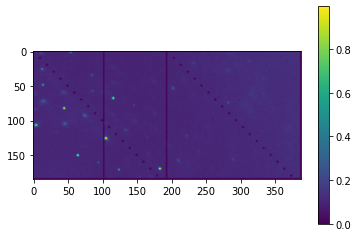

In [ ]:
a=image(xy)
print(a,a.shape)
b=a.reshape(img_shape).detach().cpu().numpy()
plt.imshow(b[:,:,0]); plt.colorbar(); plt.show()

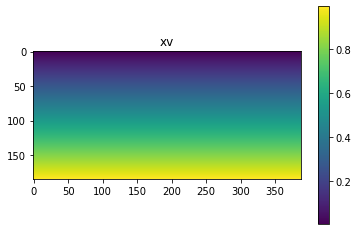

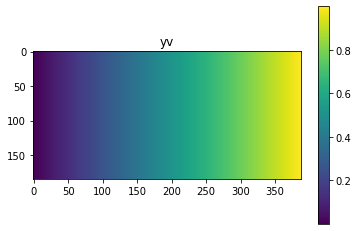

In [ ]:
plt.imshow(torch.Tensor.cpu(xv)); plt.title("xv"); plt.colorbar(); plt.show()
plt.imshow(torch.Tensor.cpu(yv)); plt.title("yv"); plt.colorbar(); plt.show()

In [ ]:
batch = torch.rand([batch_size, 2], device=device, dtype=torch.float32)
targets = traced_image(batch)
output = model(batch)

tensor([[0.1703, 0.2200],
        [0.7375, 0.4878],
        [0.0432, 0.1220],
        [0.2203, 0.3226],
        [0.5404, 0.4372],
        [0.9018, 0.1354],
        [0.6575, 0.9146],
        [0.6931, 0.0659],
        [0.1688, 0.8450],
        [0.8235, 0.5301]], device='cuda:0')
65536 torch.Size([65536, 1]) torch.Size([65536, 1])
float32


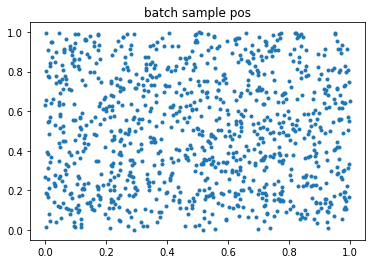

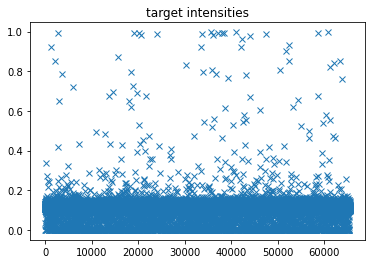

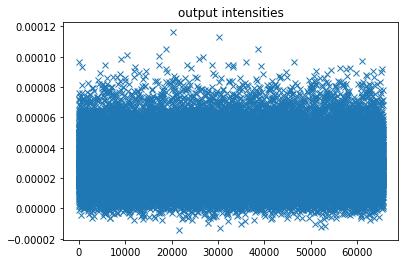

In [ ]:
print(batch[:10,:])
print(batch_size, targets.shape, output.shape)
batch_np = torch.Tensor.cpu(batch).detach().numpy()
targets_np = torch.Tensor.cpu(targets).detach().numpy()
output_np = torch.Tensor.cpu(output).detach().numpy()
print(batch_np.dtype)
plt.plot(batch_np[:1000,0], batch_np[:1000,1],'.'); plt.title("batch sample pos"); plt.show()
plt.plot(targets_np,'x'); plt.title("target intensities"); plt.show()
plt.plot(output_np,'x'); plt.title("output intensities"); plt.show()

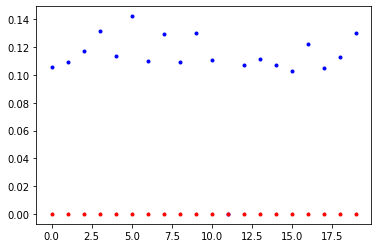

In [ ]:
plt.plot(torch.Tensor.cpu(targets)[:20],'b.');
plt.plot(torch.Tensor.cpu(output).detach().numpy()[:20],'r.'); plt.show()

float32 torch.float32


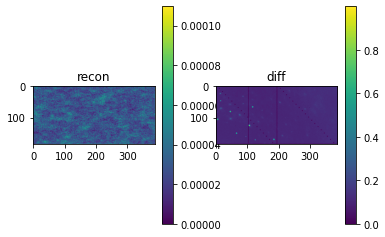

In [ ]:
recon = model(xy).reshape(img_shape).clamp(0.0, 1.0).detach().cpu().numpy().astype(np.float32)
print(recon.dtype, img.dtype)
plt.subplot(121)
plt.imshow(recon[:,:,0]); plt.title("recon"); plt.colorbar();
diff = torch.Tensor.cpu(img) - recon[:,:,0]
#print(img.shape, recon.shape, diff.shape)
plt.subplot(122)
plt.imshow(diff); plt.title("diff"); plt.colorbar(); plt.show()

In [ ]:
args.n_steps = 10000
interval = 10
for i in range(args.n_steps):
  # random xy positions
  batch = torch.rand([batch_size, 2], device=device, dtype=torch.float32) # [65536, 2]
  batch[0] = torch.tensor([151,66])
  batch[1] = torch.tensor([150,66])
  batch[2] = torch.tensor([151,65])
  batch[3] = torch.tensor([152,66])
  batch[4] = torch.tensor([151,67])
  batch[5] = torch.tensor([152,67])
  # interpolate target intensities at positions xy
  targets = traced_image(batch) # [65536, 1]
  # model output intensities at positions xy
  output = model(batch) # [65536, 1]

  relative_l2_error = (output - targets.to(output.dtype))**2 / (output.detach()**2 + 0.01)
  loss = relative_l2_error.mean()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % interval == 0:
    loss_val = loss.item()
    torch.cuda.synchronize()
    elapsed_time = time.perf_counter() - prev_time
    print(f"Step#{i}: loss={loss_val} time={int(elapsed_time*1000000)}[µs]")

    path = f"{i}.jpg"
    print(f"Writing '{path}'... ", end="")
    with torch.no_grad():
      write_image(path, model(xy).reshape(img_shape).clamp(0.0, 1.0).detach().cpu().numpy())
    print("done.")

    # Ignore the time spent saving the image
    prev_time = time.perf_counter()

    if i > 0 and interval < 1000:
      interval *= 10

if args.result_filename:
  print(f"Writing '{args.result_filename}'... ", end="")
  with torch.no_grad():
    write_image(args.result_filename, model(xy).reshape(img_shape).clamp(0.0, 1.0).detach().cpu().numpy())
  print("done.")

tcnn.free_temporary_memory()

Step#0: loss=0.00011521577835083008 time=72075714[µs]
Writing '0.jpg'... done.
Step#10: loss=0.00010001659393310547 time=41001[µs]
Writing '10.jpg'... done.
Step#100: loss=7.462501525878906e-05 time=310584[µs]
Writing '100.jpg'... done.
Step#1000: loss=7.891654968261719e-05 time=2380927[µs]
Writing '1000.jpg'... done.
Step#2000: loss=7.349252700805664e-05 time=2738204[µs]
Writing '2000.jpg'... done.
Step#3000: loss=7.635354995727539e-05 time=2951283[µs]
Writing '3000.jpg'... done.
Step#4000: loss=7.49826431274414e-05 time=2663667[µs]
Writing '4000.jpg'... done.
Step#5000: loss=7.718801498413086e-05 time=2665290[µs]
Writing '5000.jpg'... done.
Step#6000: loss=8.541345596313477e-05 time=2668472[µs]
Writing '6000.jpg'... done.
Step#7000: loss=9.036064147949219e-05 time=2867135[µs]
Writing '7000.jpg'... done.
Step#8000: loss=8.374452590942383e-05 time=2852795[µs]
Writing '8000.jpg'... done.
Step#9000: loss=0.000141143798828125 time=2671985[µs]
Writing '9000.jpg'... done.


float32 torch.float32


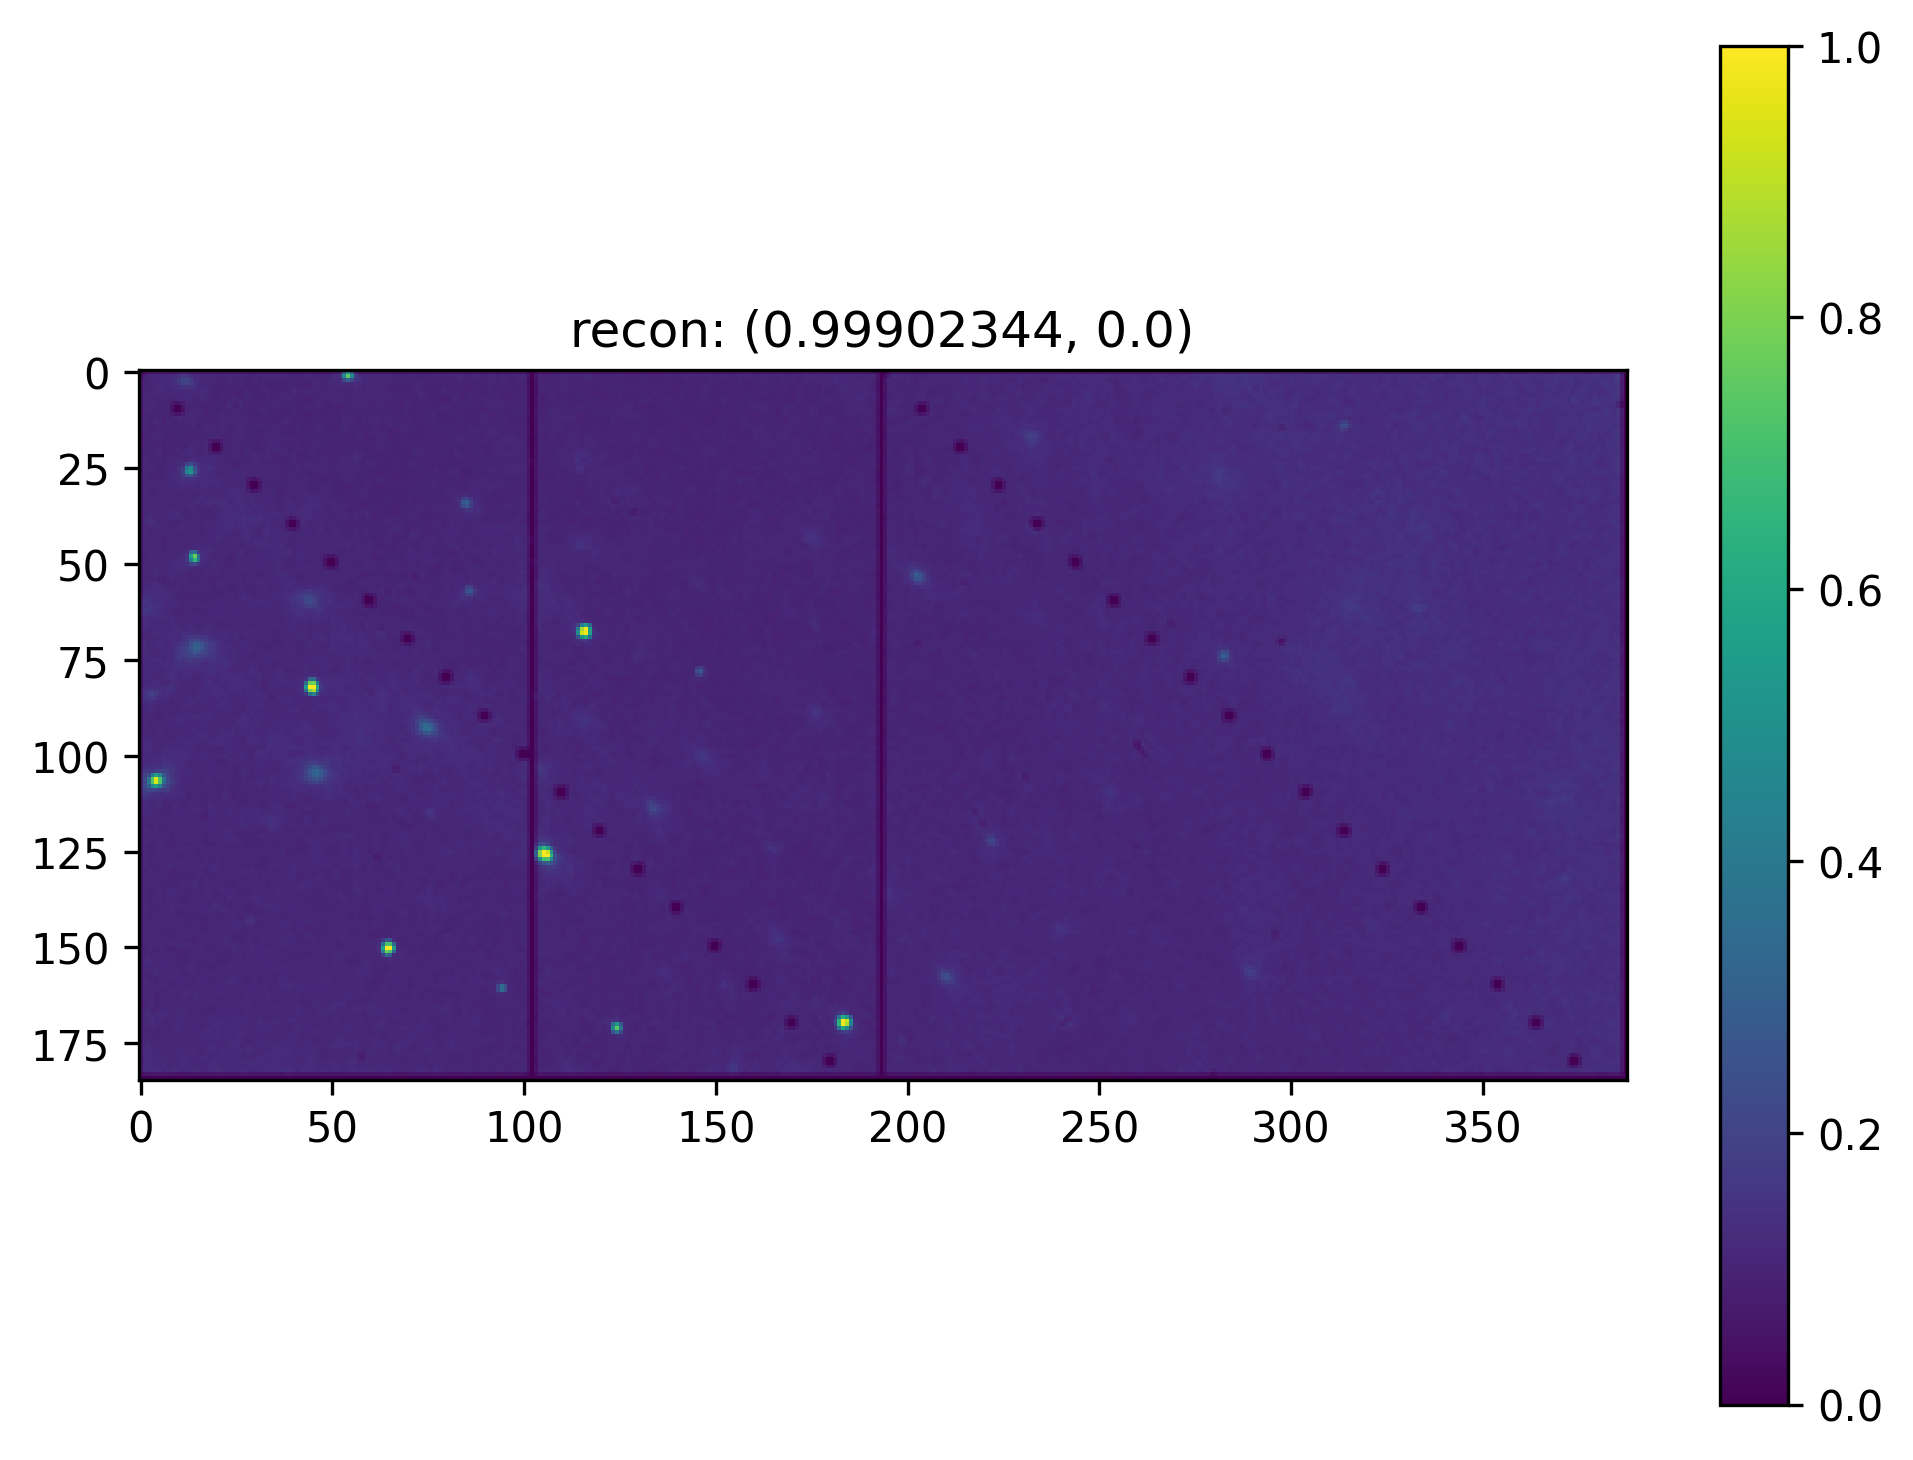

torch.Size([185, 388]) (185, 388, 1) (185, 388)
[[ 0.         -0.02658081 -0.05325317 ... -0.08666992 -0.04373169
   0.        ]
 [-0.02859497 -0.08410645  0.00370964 ... -0.00858863  0.08361246
   0.        ]
 [-0.05484009  0.00646685 -0.00101491 ... -0.00296038  0.08413368
   0.        ]
 ...
 [-0.06420898 -0.00054212 -0.00255819 ... -0.01523548  0.05966029
   0.        ]
 [-0.0335083   0.06564741  0.05015635 ...  0.06842528  0.10499717
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] float32 0.6431817 -0.57316464


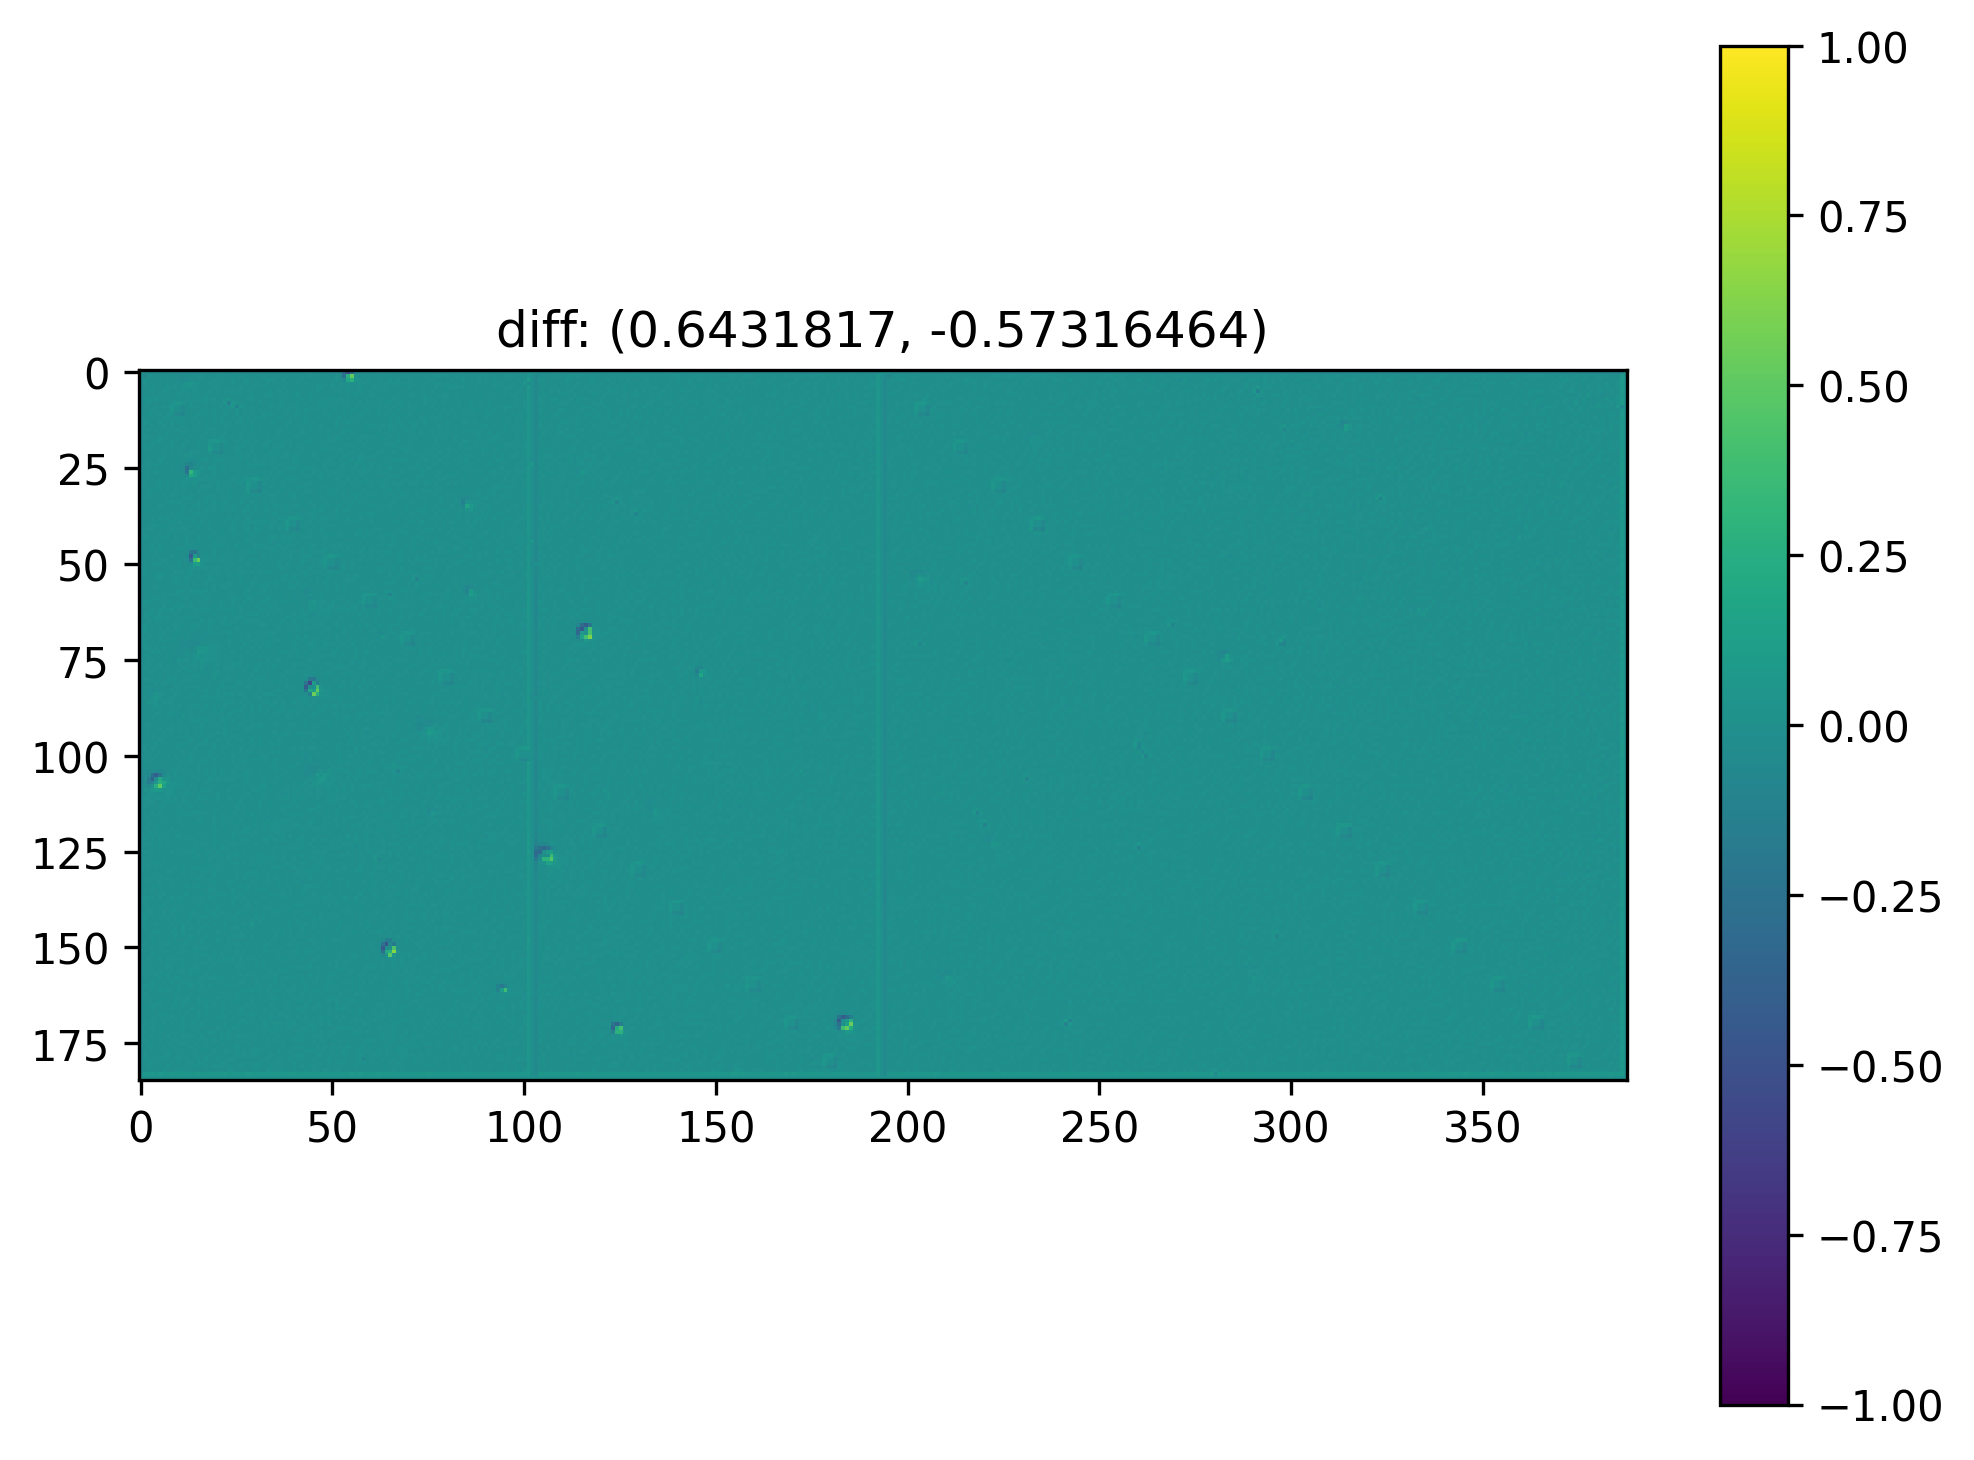

In [ ]:
#recon = model(xy).reshape(img_shape).clamp(0.0, 1.0).detach().cpu().numpy().astype(np.float32)
recon = model(xy).reshape(img_shape).detach().cpu().numpy().astype(np.float32)
print(recon.dtype, img.dtype)
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(recon[:,:,0],interpolation='none',vmin=0,vmax=1); plt.title(f"recon: {np.max(recon), np.min(recon)}"); plt.colorbar(); plt.show()
diff = torch.Tensor.cpu(img).detach().numpy() - recon[:,:,0]
print(img.shape, recon.shape, diff.shape)
print(diff, diff.dtype, np.max(diff), np.min(diff))
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(diff,interpolation='none',vmin=-1,vmax=1); plt.title(f"diff: {np.max(diff), np.min(diff)}"); plt.colorbar(); plt.show()

(array([151]), array([66]))
(array([81]), array([44]))


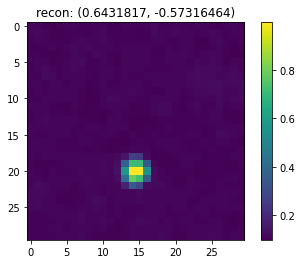

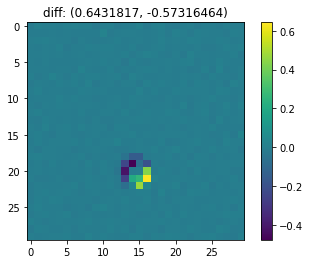

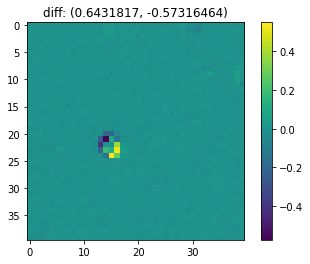

In [ ]:
# Look at where big discrepancies are
print(np.where(diff==np.max(diff)))
print(np.where(diff==np.min(diff)))
plt.imshow(recon[130:160,50:80,0],interpolation='none'); plt.title(f"recon: {np.max(diff), np.min(diff)}"); plt.colorbar(); plt.show()
plt.imshow(diff[130:160,50:80],interpolation='none'); plt.title(f"diff: {np.max(diff), np.min(diff)}"); plt.colorbar(); plt.show()
plt.imshow(diff[60:100,30:70],interpolation='none'); plt.title(f"diff: {np.max(diff), np.min(diff)}"); plt.colorbar(); plt.show()

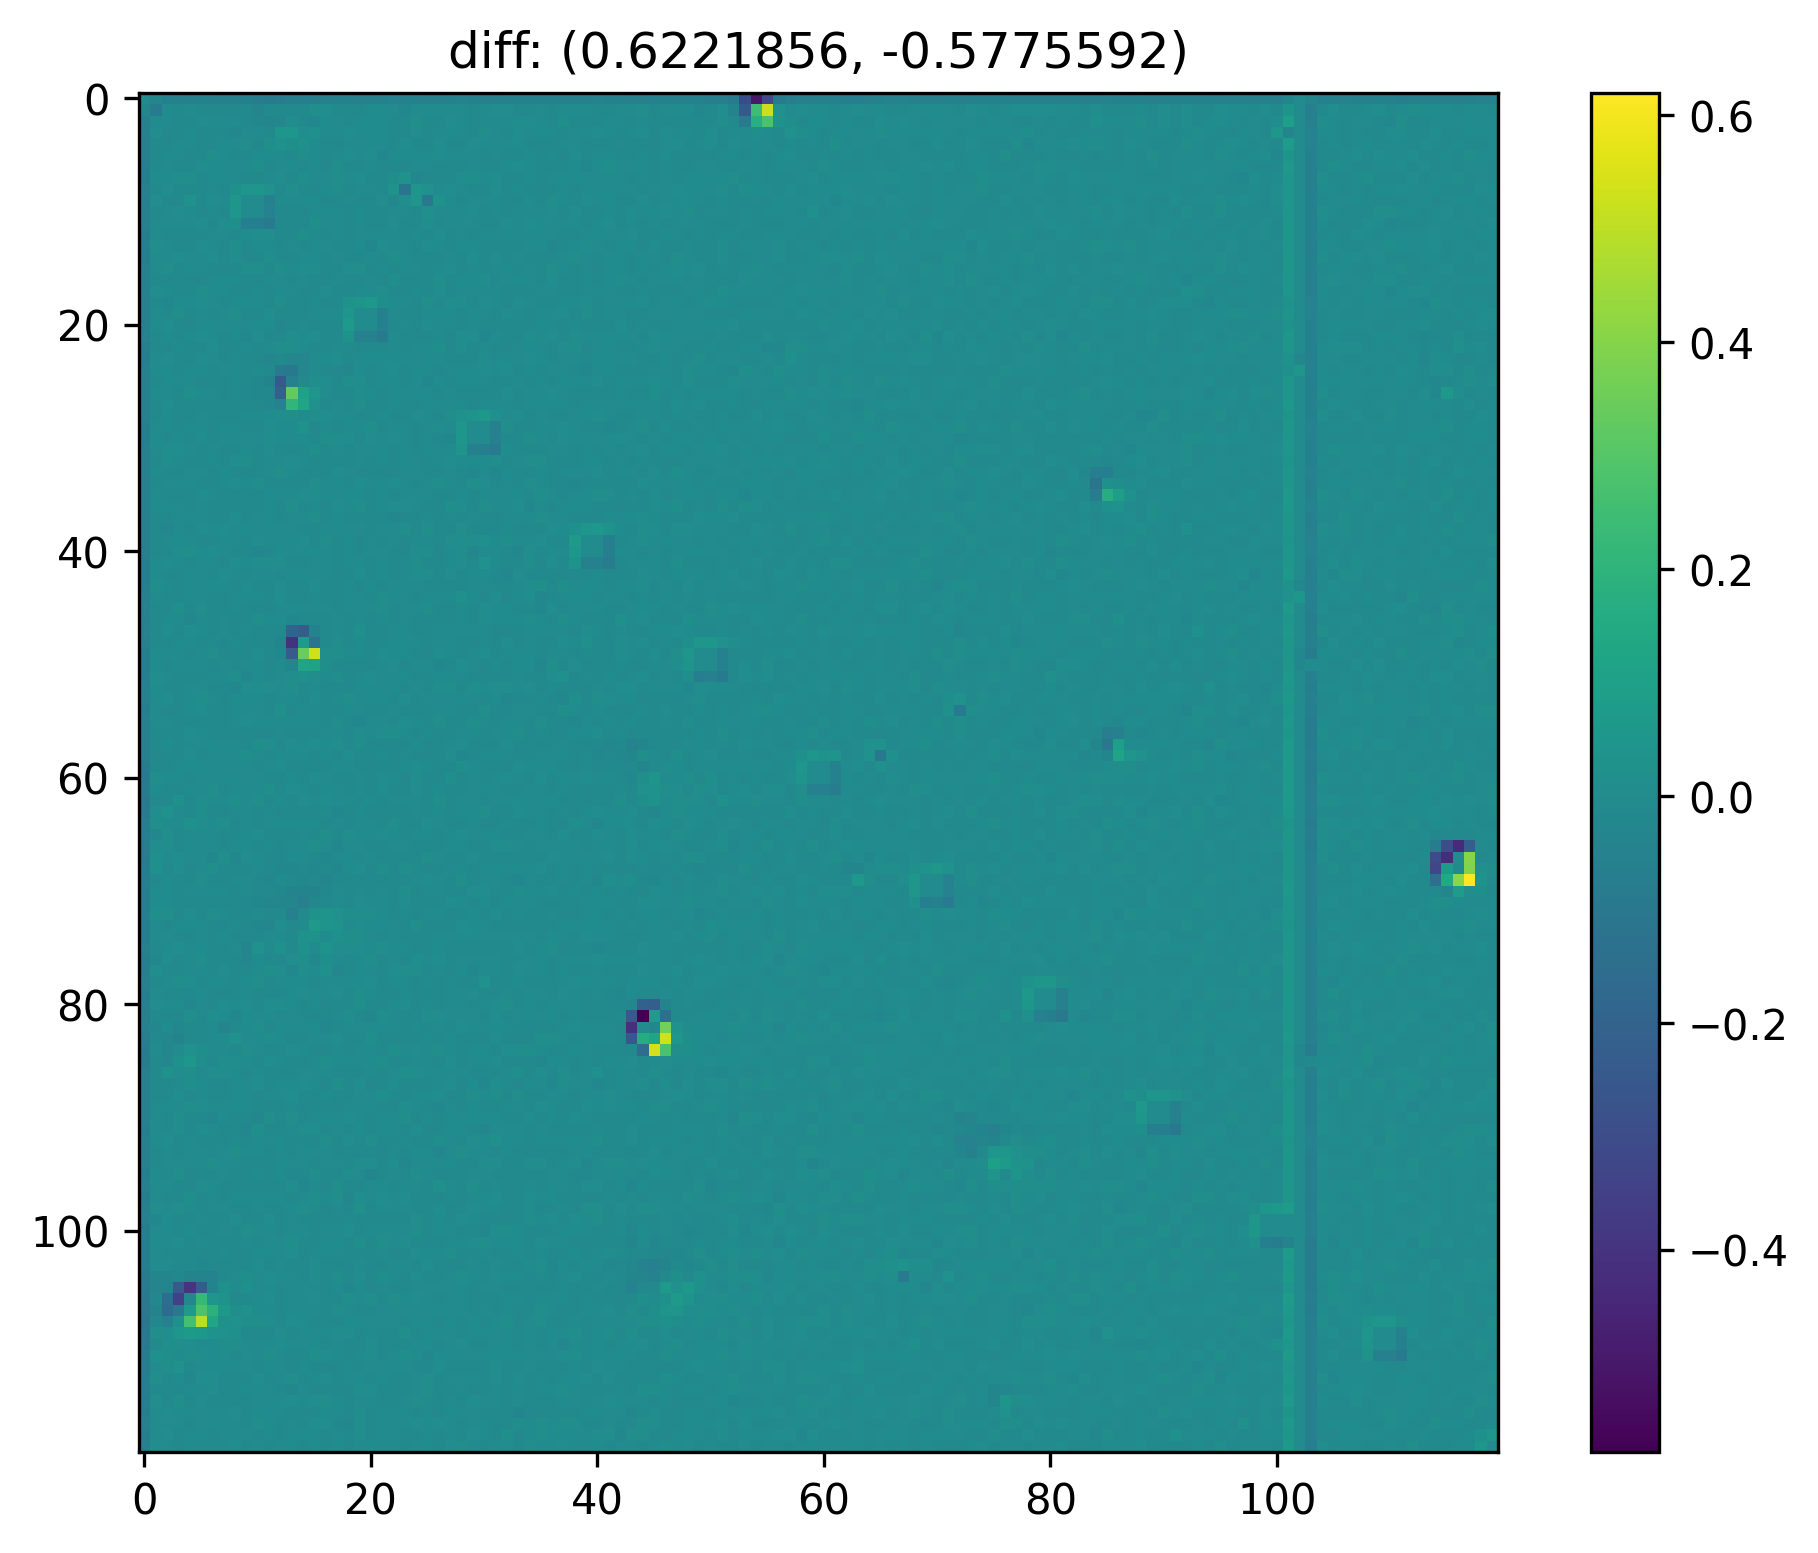

In [ ]:
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(diff[0:120,0:120],interpolation='none'); plt.title(f"diff: {np.max(diff), np.min(diff)}"); plt.colorbar(); plt.show()

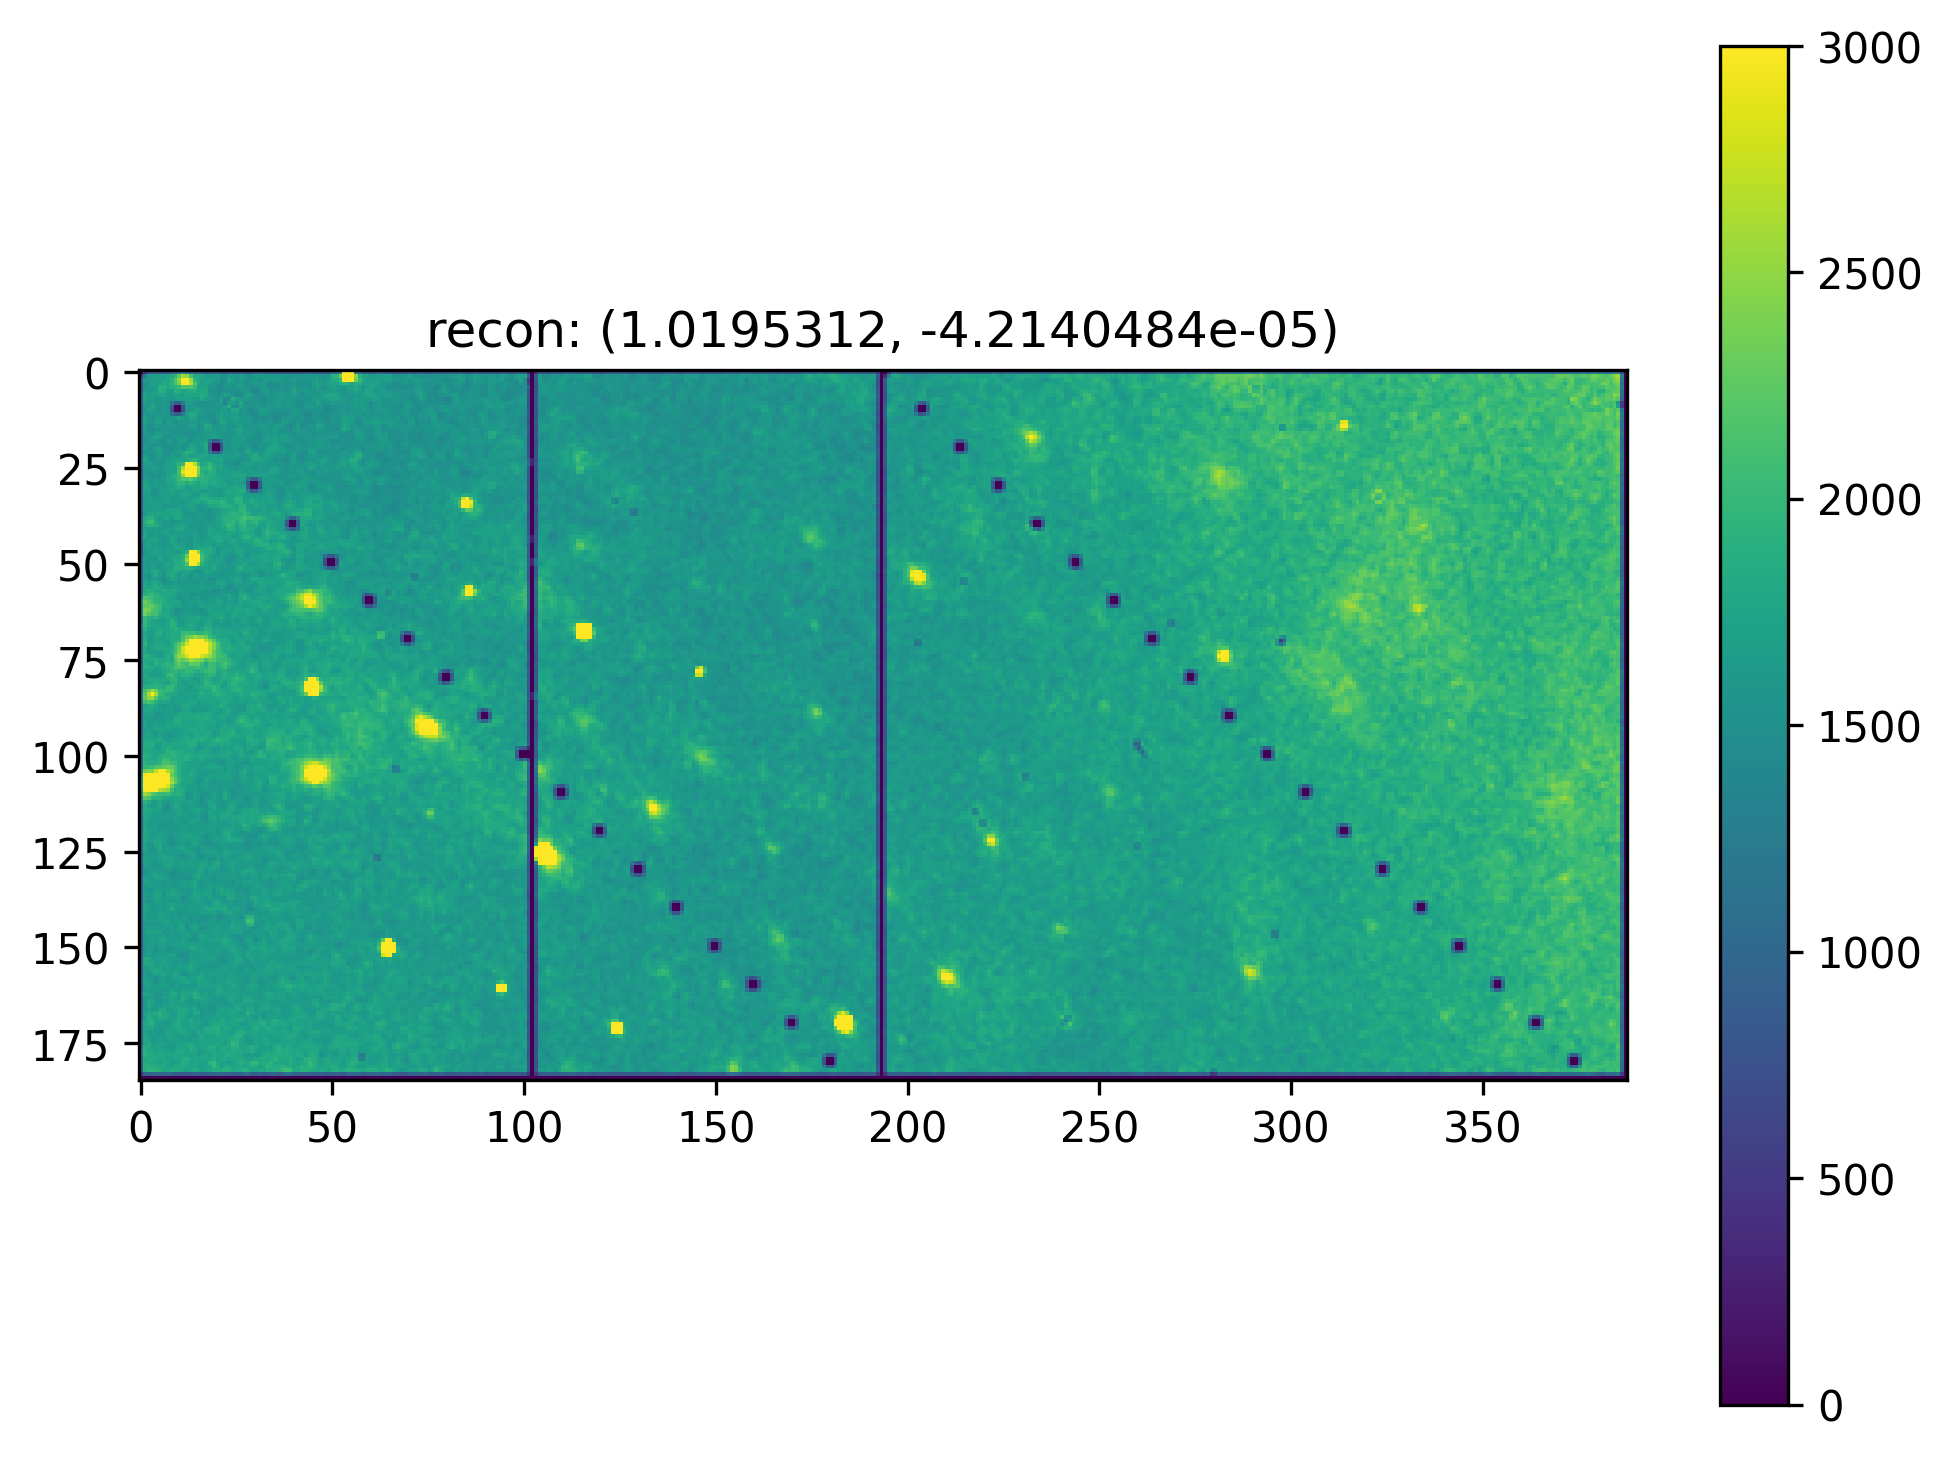

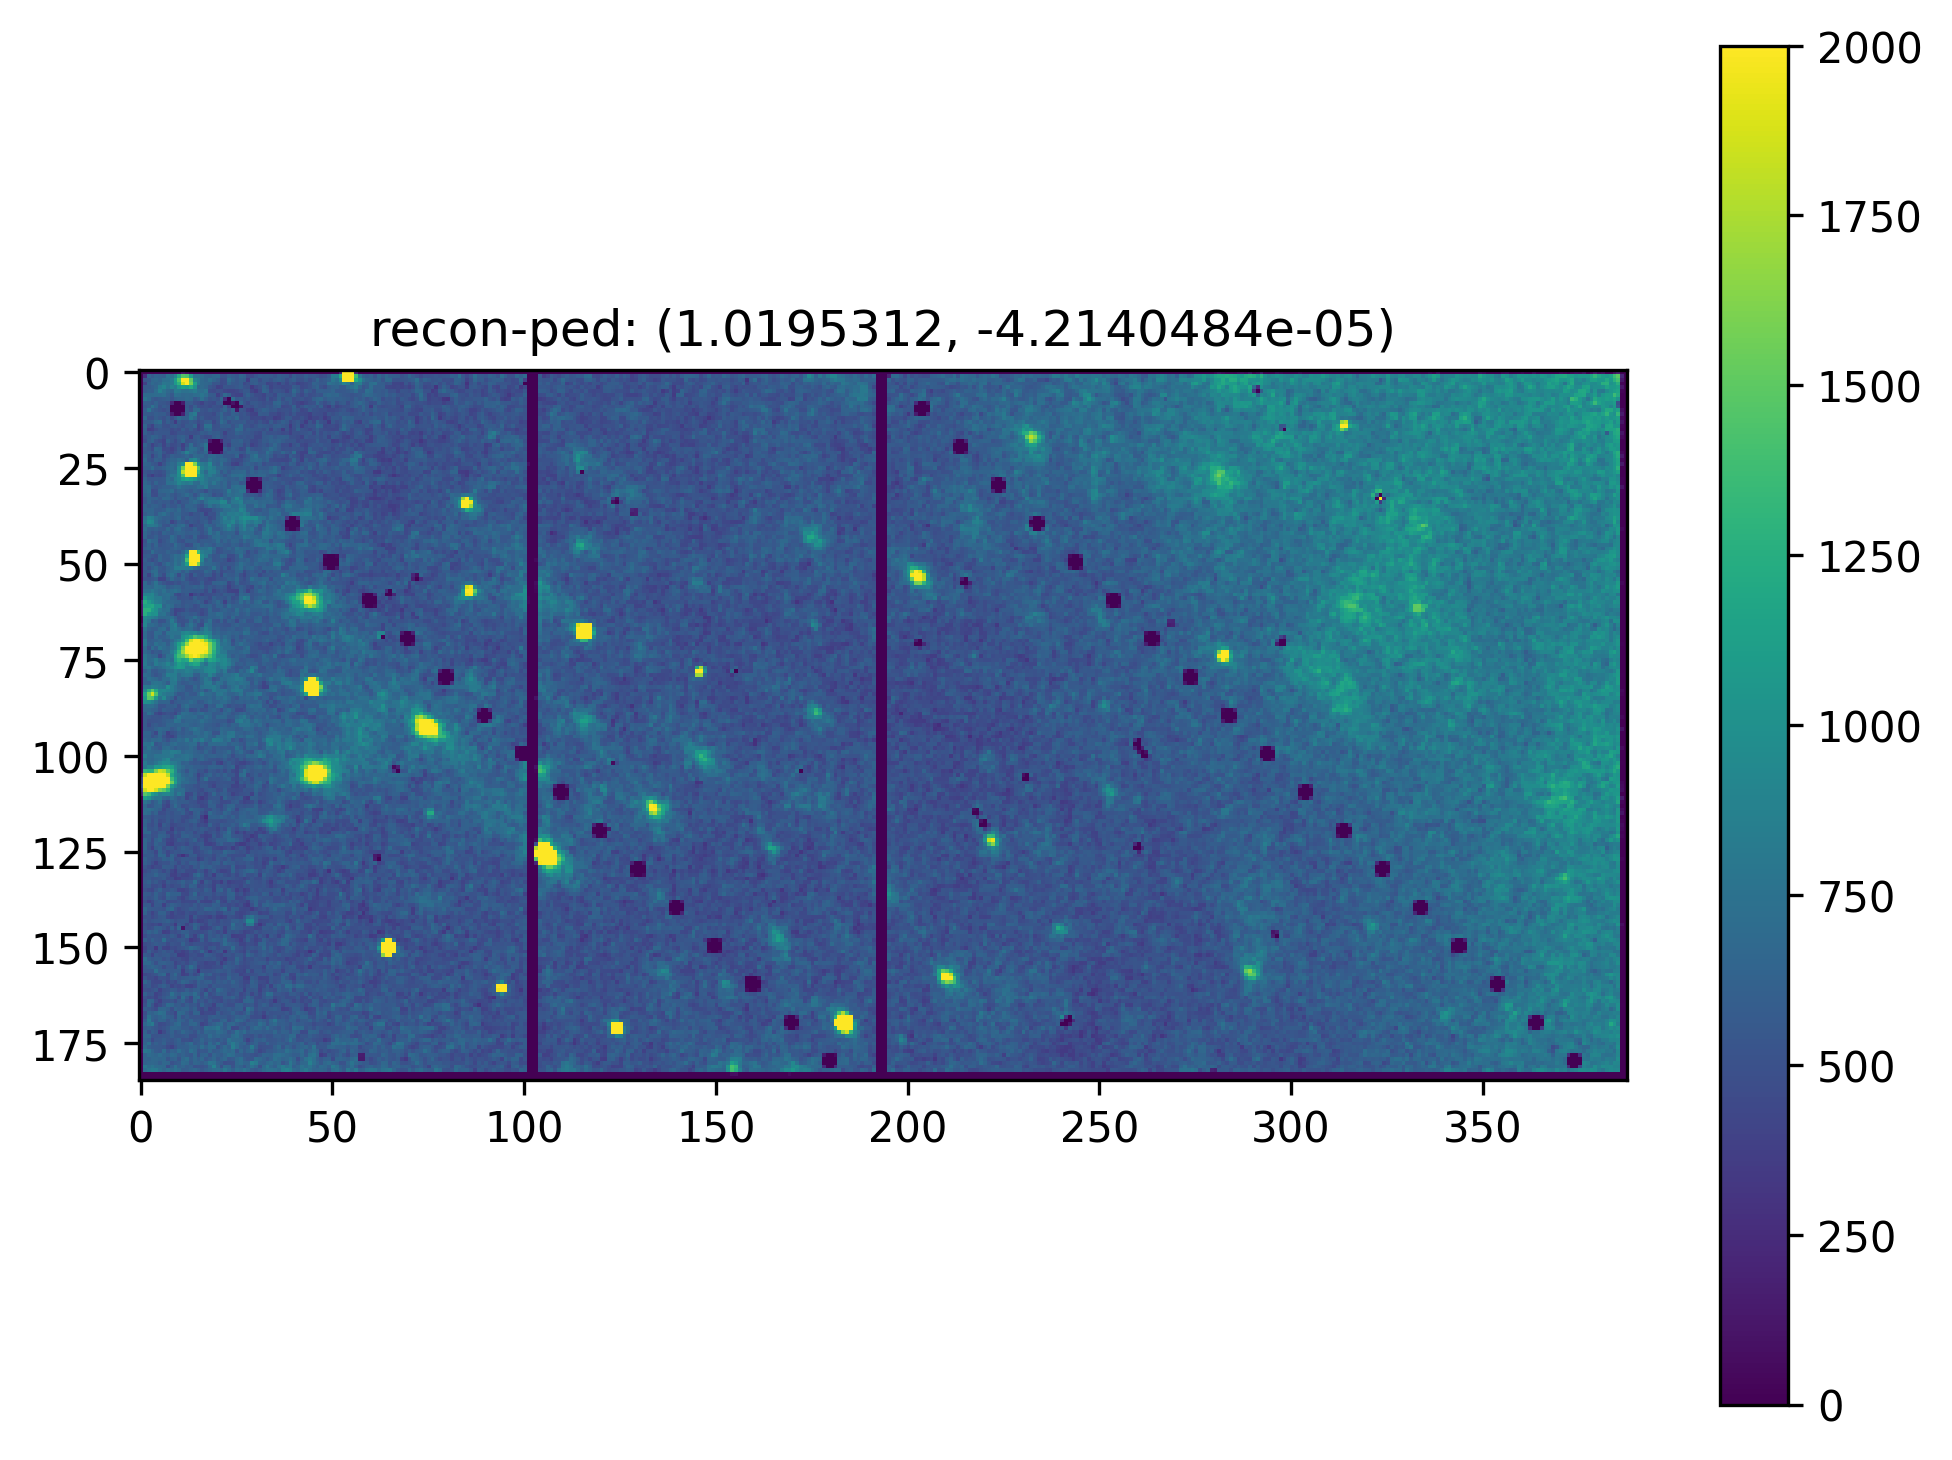

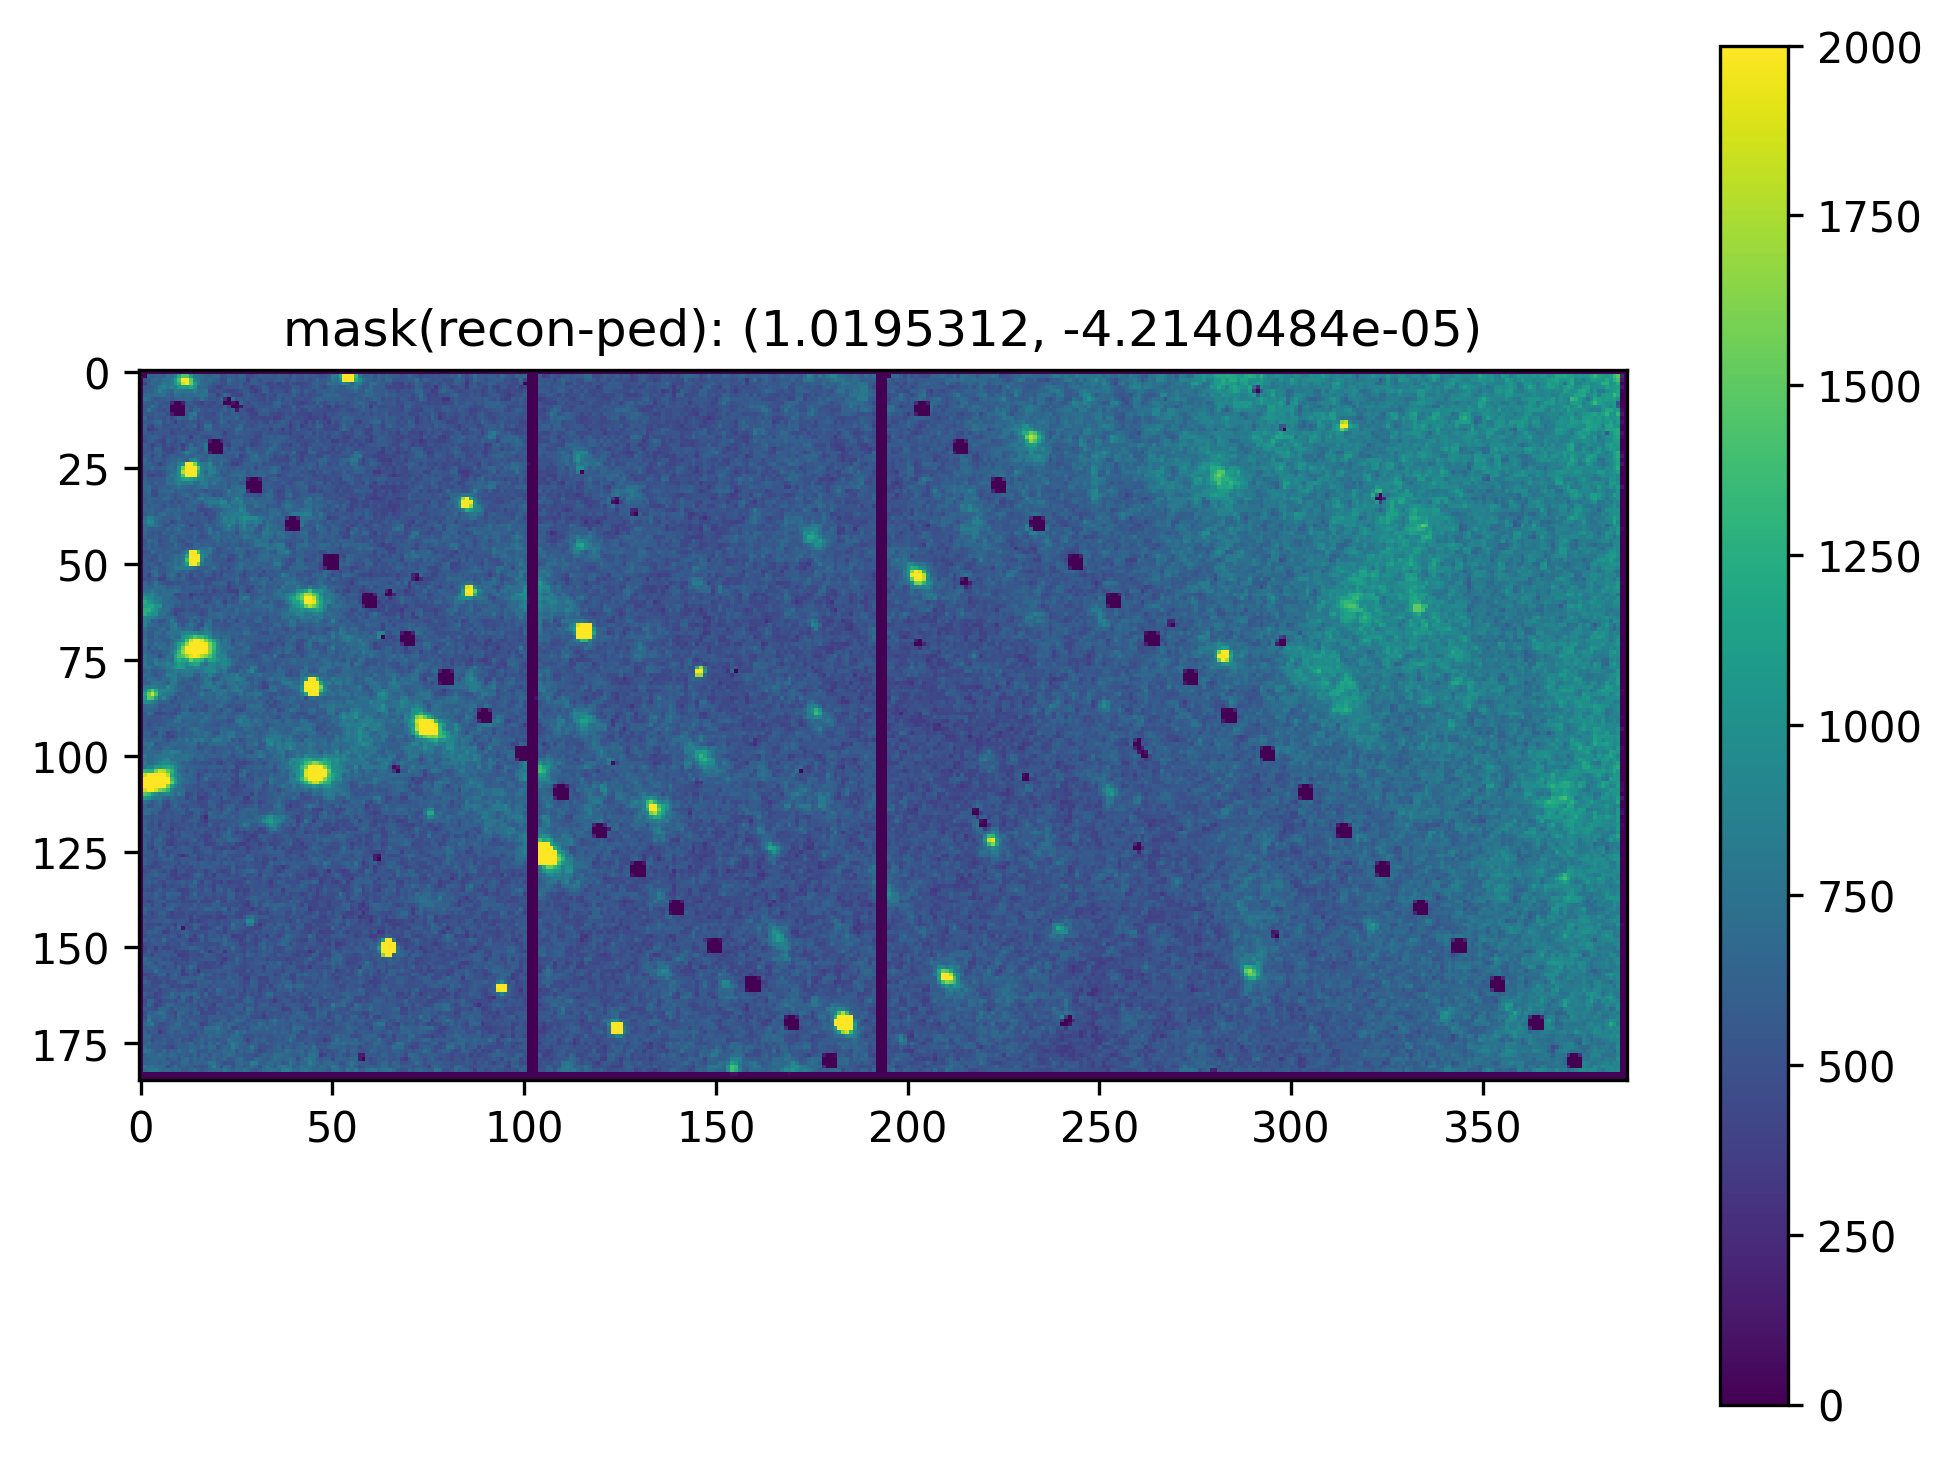

In [ ]:
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(recon[:,:,0]*maxR-minR,interpolation='none',vmin=0,vmax=3000); plt.title(f"recon: {np.max(recon), np.min(recon)}"); plt.colorbar(); plt.show()
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow(recon[:,:,0]*maxR-minR-ped[seg],interpolation='none',vmin=0,vmax=2000); plt.title(f"recon-ped: {np.max(recon), np.min(recon)}"); plt.colorbar(); plt.show()
plt.figure(figsize=(8, 6), dpi=300)
plt.imshow((recon[:,:,0]*maxR-minR-ped[seg])*mask[seg],interpolation='none',vmin=0,vmax=2000); plt.title(f"mask(recon-ped): {np.max(recon), np.min(recon)}"); plt.colorbar(); plt.show()